In [1]:
############ Time Series of Spatially-Averaged SSC, Waves, Currents, Bed Stress, etc. ############
# The purpose of this script is to calculate the spatially-averaged SSC in different sections
# of the shelf and compare them to spatially-averaged bed shear stress, waves, currents, etc.
# in the same section to see which factors contribute to changes in SSC over time in different 
# sections fo the shelf.
#
# Notes:
# - This script has the code for the data processing but this needs to be done in the 
#   *.py version of this script since it requires more RAM than is allowed on Alpine login node
# - This script can also read in the post-processed data and plot it
# - Note that we only trust model until November 1 hour 1 so things have been trimmed to match that
###################################################################################################

In [2]:
# Load in the packages 
import numpy as np
import xarray as xr
import xesmf as xe
import pandas as pd
from matplotlib.ticker import MaxNLocator
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib
from matplotlib import gridspec
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib import transforms 
from matplotlib import cm, ticker
from glob import glob
import xroms
import cmocean
#import matplotlib.ticker as tick
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import matplotlib.colors as mcolors

In [3]:
# Set a universal fontsize
fontsize = 25

# Set the tick size for all plots
matplotlib.rc('xtick', labelsize=12) 
matplotlib.rc('ytick', labelsize=12)

# Prevent tick labels from overlapping
matplotlib.rcParams['xtick.major.pad'] = 12
matplotlib.rcParams['ytick.major.pad'] = 12

In [4]:
# Load in the grid
grid = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Include/KakAKgrd_shelf_big010_smooth006.nc')
#grid = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Grids/KakAKgrd_shelf_big010_smooth006.nc') # UPDATE PATH


# Pull out some dimensions
eta_rho_len = len(grid.eta_rho)
xi_rho_len = len(grid.xi_rho)
s_rho_len = int(20)
Nbed_len = 11

# Multiply by masks to make land appear 
# Make it so land will appear
temp_mask = grid.mask_rho.copy()
temp_mask = np.where(temp_mask==0, np.nan, temp_mask)


# Load in the rho masks 
mask_rho_nan = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_ones_nans.nc') # UPDATE PATH
mask_rho_zeros = xr.open_dataset('/projects/brun1463/ROMS/Kakak3_Alpine/Scripts_2/Analysis/Nudge_masks/nudge_mask_rho_zeros_ones.nc')
#mask_rho_nan = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_ones_nans.nc')
#mask_rho_zeros = xr.open_dataset('/Users/brun1463/Desktop/Research_Lab/Kaktovik_Alaska_2019/Code/Nudge_masks/nudge_mask_rho_zeros_ones.nc')

In [5]:
# -------------------------------------------------------------------------------------
# ----------------------- Define a Bunch o Functions ----------------------------
# -------------------------------------------------------------------------------------

# Define a function to pull out the length of time in the model run
# And the time steps
def get_model_time(filenames, num_files):
    """
    This function loops though model output and pulls
    out the entire length of the run, as well as the 
    individual time steps of the run.
    
    Inputs:
    - filenames: path and name of model output
    - num_files: the number of model output files
    
    Outputs:
    - time_len: length of time of model run (integer)
    - time_steps_list: list of time steps of full run (datetimes64)
    - time_lengths: array holding the lenght of time of each output file
    """

    # Create an array to hold the length of time in each output file
    time_lengths = np.empty((num_files))

    # Loop through output to pull out lenth of time
    for k in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[k])

        # Pull out the length of time 
        time_lengths[k] = len(model_output.ocean_time)

    # Now sum over all the lengths to get total time
    time_len = np.sum(time_lengths, axis=0)

    # Convert from float to int
    time_len = int(time_len)

    # Loop back through the output to pull out the time step and save it
    # Make a list to hold the time steps 
    time_steps_list = []
    # Loop through output
    for h in range(num_files):
        # Open the output file
        model_output = xr.open_dataset(filenames[h])

        # Get the length of the run
        output_len = len(model_output.ocean_time)

        # Loop through each time step and append it to the list
        for g in range(output_len):
            time_steps_list.append(model_output.ocean_time[g].values)

    # Return this time length and time steps
    return(time_len, time_steps_list, time_lengths)

In [6]:
# Make functions to help with masking 
# Make masks to isolate each region, starting with breaking things up by depth 
# Make a function to mask the data
def masked_array(data, threshold):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    return (data <= threshold).astype(int)

# Make a function to mask the data but that takes two thresholds
def masked_array_lowhigh_2dloop(data, lower, upper):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    mask_tmp = np.empty_like((data))
    
    # Loop through dimension 1
    for i in range(len(data[:,0])):
        # Loop through dimension 2
        for j in range(len(data[0,:])):
            # Compare against threshold 
            value = data[i,j]
            if lower < value <= upper:
                mask_tmp[i,j] = 1
            else:
                mask_tmp[i,j] = 0
    
    
    return (mask_tmp).astype(int)

# Make a function to mask the data - higher
def masked_array_higher(data, threshold):
    """
    This function takes an array and masks all values that are less
    than a certain given threshold. The functions returns 1 for areas that meet 
    the condition and 0 for areas that don't. So areas where the array is less
    than the threshold get returned as 1 and areas greater than the threshold
    are returned as 0. This function maintains the shape of the array.
    
    """
    return (data >= threshold).astype(int)

In [7]:
# Make a function to calculate the depth-integrated SSC and 
# depth-averaged SSC for all sediment class
def calc_depth_int_avg_ssc_allsed(filename):
    """
    The purpose of this function is to take a given model output file, load 
    in the output, and caluclate the depth-integrated and depth-averaegd 
    suspended sediment concentrations (SSC) for all sediment classes

    Parameters
    ----------
    filename : The name/path of the model output file.

    Returns
    -------
    depth_int_ssc_allsed: Spatail time series of depth-integrated SSC for 
    all sediment classes (kg/m2)
    depth_avg_ssc_allsed: Spatial time series of depth-averaged ssc for a 
    all sediment classes (kg/m3)

    """
    
    # Load in the model output
    model_output = xr.open_dataset(filename)
    
    # Pull out the sediment class of interest
    ssc_allsed_tmp = (model_output.sand_01 + model_output.sand_02 + model_output.sand_03 + model_output.mud_01 + model_output.mud_02 + model_output.mud_03 +
                      model_output.mud_04 + model_output.mud_05 + model_output.mud_06 + model_output.mud_07 + model_output.mud_08 + model_output.mud_09 +
                      model_output.mud_10 + model_output.mud_11 + model_output.mud_12 + model_output.mud_13 + model_output.mud_14 + model_output.mud_15 +
                      model_output.mud_16 + model_output.mud_17 + model_output.mud_18 + model_output.mud_19 + model_output.mud_20 + model_output.mud_21 +
                      model_output.mud_22 + model_output.mud_23 + model_output.mud_24)
    
    # To collapse to horizontal, multiply each layer by its
    # thickness
    # Calculate the time-varying thickness of the cells
    dz = abs(model_output.z_w[:,:-1,:,:].values - model_output.z_w[:,1:,:,:].values)
    
    # Calculate depth-integrated ssc
    depth_int_ssc_allsed = (((ssc_allsed_tmp*dz)).sum(dim='s_rho'))
    
    # Divide by bathymetry to get depth-averaged SSC (kg/m3)
    depth_avg_ssc_allsed = depth_int_ssc_allsed/model_output.bath[:,:,:].values
    
    # Return the depth-integrated u flux for all sediment classes
    return(depth_int_ssc_allsed, depth_avg_ssc_allsed)

In [8]:
# Make a function that does everything that is done below for a given sediment class
def get_timeseries_depth_int_avg_ssc_allsed(file_names, time_lengths, full_time_len, eta_rho_len, xi_rho_len):
    """
    The purpose of this function is to get out two time series of the kg of sediment 
    per layer in the seabed and the frac of sediment per layer in the seabed for 
    all sediment classes (total SSC)
    

    Parameters
    ----------
    file_names : list of path and names of model outputs
    time_lengths : List of lengths of time in each output file 
    full_time_len : Lenght of time of all model output
    eta_rho_len : Length of eta_rho points
    xi_rho_len : Length of xi_rho points

    Returns
    -------
    None.

    """
    
    # Make empty arrays to hold the time series
    depth_int_ssc_allsed = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_allsed = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    
    #
    # Set a time step to track which time step the loop is on
    time_step = 0

    # Get number of files
    num_files = len(file_names)

    # Loop through the model output
    for j in range(num_files):
    #for j in range(1):

        print('j: ', j, flush=True)
        
        # Prep time for saving to arrays
        #print('time_step: ', time_step)
        #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
        start = int(time_step)
        end = int(time_step+time_lengths[j])
        
        # Call the function to process the output - mass in seabed
        depth_int_ssc_allsed[start:end,:,:], depth_avg_ssc_allsed[start:end,:,:] = calc_depth_int_avg_ssc_allsed(file_names[j])
        
        # Update the base time_step
        time_step = time_step + time_lengths[j]
    
    # Return these arrays 
    return(depth_int_ssc_allsed, depth_avg_ssc_allsed)

In [9]:
# Define a bunch of functions to process the data

# Function to load in model output, pull out the variables
# for a given section, average them spatially over that section,
# then return them
# Probably want this function to do all sections at a time 
# since we do not want to have to re-open the output several 
# time for each section 

# Note: This might need to be done in a *.py script since I 
# am guessing this will run out of RAM but make sure it works
# for at least one output file before making the *.py counterpart; 
# then can plot in this script but use it for code development for now


# Make a function to open model output, multiply different variables
# by masks for different sections, spatially-average, then return time
# series 
def get_time_series_ssc_waves_cur_bstr_by_section(filenames, wave_frc, full_time_len, temp_mask, depth_int_ssc, regridder_u2rho, regridder_v2rho, seabed_sec1_mask, seabed_sec2_mask,
                             seabed_sec3_mask, seabed_sec4_mask, seabed_sec5_mask, seabed_sec6_mask,
                             seabed_sec7_mask, seabed_sec8_mask, seabed_sec9_mask, seabed_sec10_mask,
                             seabed_sec11_mask, seabed_sec12_mask, seabed_sec13_mask):
    """
    This function loops through model output files, multiplies several variables 
    by all of the shelf section masks to get that variable in each section, then
    spatially averages/depth-integrates as needed to collapse to one value at 
    each time step. This function returns a time series for each variable in 
    each section over the model ruhn.

    Inputs:
    - filenames: list continaing paths of file names for ROMS output
    - full_time_len : Number of time steps in the array/model output
    - temp_mask : Variable containing the land mask of the grid 
    - seabed_sec1_mask : Mask for Seabed Section 1
    - seabed_sec2_mask : Mask for Seabed Section 2
    - seabed_sec3_mask : Mask for Seabed Section 3
    - seabed_sec4_mask : Mask for Seabed Section 4
    - seabed_sec5_mask : Mask for Seabed Section 5
    - seabed_sec6_mask : Mask for Seabed Section 6
    - seabed_sec7_mask : Mask for Seabed Section 7
    - seabed_sec8_mask : Mask for Seabed Section 8
    - seabed_sec9_mask : Mask for Seabed Section 9
    - seabed_sec10_mask : Mask for Seabed Section 10
    - seabed_sec11_mask : Mask for Seabed Section 11
    - seabed_sec12_mask : Mask for Seabed Section 12
    - seabed_sec13_mask : Mask for Seabed Section 13

    Outputs:
    - 
    """

    # Set the number of masks/sections
    num_seabed_sections = 13

     # Get number of files
    num_files = len(filenames)
    
    # Make an empty array to hold the output 
    ssc_summed_masked = np.empty((full_time_len, num_seabed_sections))

    # Make empty arrays to hold the final values
    ssc_avg_masked = np.empty((full_time_len, num_seabed_sections))
    Hwave_avg_masked = np.empty((len(wave_frc.wave_time), num_seabed_sections))
    cur_mag_1mab_masked = np.empty((full_time_len, num_seabed_sections))
    bstr_avg_masked = np.empty((full_time_len, num_seabed_sections))

    # Loop through and open the output
    # Set the initial time step
    time_step = 0
    time_step2 = 0
    
    # Loop through each output file
    for jj in range(num_files):
        print('jj:' , jj, flush=True)

        # Load in the ROMS output 
        model_output = xr.open_dataset(filenames[jj])

        print('Loaded the output', flush=True)

        # Interpolate u and v currents onto rho points
        u_rho = regridder_u2rho(model_output.u)
        v_rho = regridder_v2rho(model_output.v)

        print('Regridded u and v', flush=True)

        # Open with xroms for interpolation - kernel keeps crashing here
        #ds = xr.open_dataset(filenames)
        #model_output['h'] = model_output.bath[0,:,:]
        #xmodel_output, xgrid = xroms.roms_dataset(model_output)

        #print('Made xmodel_output with xroms', flush=True)
    
        # Get the depths as height from seabed
        #height_from_seabed = xmodel_output.z_rho + xmodel_output.bath
        #height_from_seabed.name = 'z_rho'

        #print('Got depths as height from seabed', flush=True)
    
        # Set depth to interpolate to, 1 m above seafloor
        #depths = np.asarray([1.0])

        #print('Started interpolating u and v onto 1 m above seabed', flush=True)

        # Interpolate u and v on rho onto 1 m above seabed
        #u_1mab_rho = xroms.isoslice((u_rho), depths, xgrid, iso_array=height_from_seabed, axis='Z')
        #v_1mab_rho = xroms.isoslice((v_rho), depths, xgrid, iso_array=height_from_seabed, axis='Z')

        #print('Interpolated u and v onto 1 m above seafloor', flush=True)

        # Get the current magnitude 1 m above the seabed
        #cur_mag_1mab = np.sqrt((u_1mab_rho)**2 + (v_1mab_rho)**2)

        #print('Calculated current magnitude', flush=True)

        # Loop through time in that output file and multiply by mask,
        # average by section, and save to arrays
        for t in range(len(model_output.ocean_time)):
            # Get the value in each section and average over that section 
            # Section 1
            ssc_avg_masked[time_step,0] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec1_mask, axis=(0,1))
            Hwave_avg_masked[time_step,0] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec1_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,0] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec1_mask, axis=(0,1))
            bstr_avg_masked[time_step,0] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec1_mask, axis=(0,1))
            print('Done with Section 1', flush=True)
            # Section 2
            ssc_avg_masked[time_step,1] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec2_mask, axis=(0,1))
            Hwave_avg_masked[time_step,1] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec2_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,1] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec2_mask, axis=(0,1))
            bstr_avg_masked[time_step,1] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec2_mask, axis=(0,1))
            print('Done with Section 2', flush=True)
            # Section 3
            ssc_avg_masked[time_step,2] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec3_mask, axis=(0,1))
            Hwave_avg_masked[time_step,2] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec3_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,2] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec3_mask, axis=(0,1))
            bstr_avg_masked[time_step,2] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec3_mask, axis=(0,1))
            print('Done with Section 3', flush=True)
            # Section 4
            ssc_avg_masked[time_step,3] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec4_mask, axis=(0,1))
            Hwave_avg_masked[time_step,3] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec4_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,3] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec4_mask, axis=(0,1))
            bstr_avg_masked[time_step,3] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec4_mask, axis=(0,1))
            print('Done with Section 4', flush=True)
            # Section 5
            ssc_avg_masked[time_step,4] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec5_mask, axis=(0,1))
            Hwave_avg_masked[time_step,4] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec5_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,4] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec5_mask, axis=(0,1))
            bstr_avg_masked[time_step,4] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec5_mask, axis=(0,1))
            print('Done with Section 5', flush=True)
            # Section 6
            ssc_avg_masked[time_step,5] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec6_mask, axis=(0,1))
            Hwave_avg_masked[time_step,5] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec6_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,5] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec6_mask, axis=(0,1))
            bstr_avg_masked[time_step,5] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec6_mask, axis=(0,1))
            print('Done with Section 6', flush=True)
            # Section 7
            ssc_avg_masked[time_step,6] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec7_mask, axis=(0,1))
            Hwave_avg_masked[time_step,6] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec7_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,6] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec7_mask, axis=(0,1))
            bstr_avg_masked[time_step,6] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec7_mask, axis=(0,1))
            print('Done with Section 7', flush=True)
            # Section 8
            ssc_avg_masked[time_step,7] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec8_mask, axis=(0,1))
            Hwave_avg_masked[time_step,7] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec8_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,7] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec8_mask, axis=(0,1))
            bstr_avg_masked[time_step,7] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec8_mask, axis=(0,1))
            print('Done with Section 8', flush=True)
            # Section 9
            ssc_avg_masked[time_step,8] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec9_mask, axis=(0,1))
            Hwave_avg_masked[time_step,8] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec9_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,8] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec9_mask, axis=(0,1))
            bstr_avg_masked[time_step,8] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec9_mask, axis=(0,1))
            print('Done with Section 9', flush=True)
            # Section 10
            ssc_avg_masked[time_step,9] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec10_mask, axis=(0,1))
            Hwave_avg_masked[time_step,9] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec10_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,9] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec10_mask, axis=(0,1))
            bstr_avg_masked[time_step,9] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec10_mask, axis=(0,1))
            print('Done with Section 10', flush=True)
            # Section 11
            ssc_avg_masked[time_step,10] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec11_mask, axis=(0,1))
            Hwave_avg_masked[time_step,10] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec11_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,10] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec11_mask, axis=(0,1))
            bstr_avg_masked[time_step,10] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec11_mask, axis=(0,1))
            print('Done with Section 11', flush=True)
            # Section 12
            ssc_avg_masked[time_step,11] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec12_mask, axis=(0,1))
            Hwave_avg_masked[time_step,11] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec12_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,11] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec12_mask, axis=(0,1))
            bstr_avg_masked[time_step,11] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec12_mask, axis=(0,1))
            print('Done with Section 12', flush=True)
            # Section 13
            ssc_avg_masked[time_step,12] = np.nanmean(depth_int_ssc[time_step,:,:]*temp_mask*seabed_sec13_mask, axis=(0,1))
            Hwave_avg_masked[time_step,12] = np.nanmean(wave_frc.Hwave[t,:,:].values*temp_mask*seabed_sec13_mask, axis=(0,1))
            #cur_mag_1mab_masked[time_step,12] = np.nanmean(cur_mag_1mab[t,:,:]*temp_mask*seabed_sec13_mask, axis=(0,1))
            bstr_avg_masked[time_step,12] = np.nanmean(model_output.bstrcwmax[t,:,:].values*temp_mask*seabed_sec13_mask, axis=(0,1))
            print('Done with Section 13', flush=True)

            # Update the time index
            time_step = time_step + 1

    # Waves are in a different loop since they are different temporal frequency
    for tt in range(len(wave_frc.wave_time)):
        # Get the value for Hwave in each section and average over that section 
        # Section 1
        Hwave_avg_masked[tt,0] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec1_mask, axis=(0,1))
        # Section 2
        Hwave_avg_masked[tt,1] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec2_mask, axis=(0,1))
        # Section 3
        Hwave_avg_masked[tt,2] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec3_mask, axis=(0,1))
        # Section 4
        Hwave_avg_masked[tt,3] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec4_mask, axis=(0,1))
        # Section 5
        Hwave_avg_masked[tt,4] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec5_mask, axis=(0,1))
        # Section 6
        Hwave_avg_masked[tt,5] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec6_mask, axis=(0,1))
        # Section 7
        Hwave_avg_masked[tt,6] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec7_mask, axis=(0,1))
        # Section 8
        Hwave_avg_masked[tt,7] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec8_mask, axis=(0,1))
        # Section 9
        Hwave_avg_masked[tt,8] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec9_mask, axis=(0,1))
        # Section 10
        Hwave_avg_masked[tt,9] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec10_mask, axis=(0,1))
        # Section 11
        Hwave_avg_masked[tt,10] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec11_mask, axis=(0,1))
        # Section 12
        Hwave_avg_masked[tt,11] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec12_mask, axis=(0,1))
        # Section 13
        Hwave_avg_masked[tt,12] = np.nanmean(wave_frc.Hwave[tt,:,:].values*temp_mask*seabed_sec13_mask, axis=(0,1))


    # Return these time series arrays
    return(ssc_avg_masked, Hwave_avg_masked, bstr_avg_masked) # cur_mag_1mab_masked,




In [10]:
# Need to find regridding weights to go from 
# u and v points to rho points 
# Set the input and output grids, and sepcify the lat/lon
# Since we are looking at u and v, we will use lon_u and lat_u as the primary lat/lon for the grid 
# and make another with lat_v and lon_v
# U input grid 
ds_in_u = grid.copy() # need to use lon_180 for this grid 
ds_in_u['lon'] = (('eta_u', 'xi_u'), ds_in_u.lon_u.values)
ds_in_u['lat'] = (('eta_u', 'xi_u'), ds_in_u.lat_u.values)
# V input grid 
ds_in_v = grid.copy() # need to use lon_180 for this grid 
ds_in_v['lon'] = (('eta_v', 'xi_v'), ds_in_v.lon_v.values)
ds_in_v['lat'] = (('eta_v', 'xi_v'), ds_in_v.lat_v.values)

# Output grid (ROMS rho grid)
ds_out_rho = grid.copy()
ds_out_rho['lat'] = (('eta_rho', 'xi_rho'), ds_out_rho.lat_rho.values)
ds_out_rho['lon'] = (('eta_rho', 'xi_rho'), ds_out_rho.lon_rho.values)

# Add masks 
# ex: ds["mask"] = xr.where(~np.isnan(ds["zeta"].isel(ocean_time=0)), 1, 0)
# Input grid (HYCOM)
# this is only a surface mask - which is what we want 
# U
ds_in_u['mask'] = (('eta_u', 'xi_u'), ds_in_u.mask_u.values)
# V
ds_in_v['mask'] = (('eta_v', 'xi_v'), ds_in_v.mask_v.values)
# Output grid (ROMS rho grid)
ds_out_rho['mask'] = (('eta_rho', 'xi_rho'), ds_out_rho.mask_rho.values)

# Regrid from u grid to rho grid with the masks included and extrapolation used 
regridder_u2rho = xe.Regridder(ds_in_u, ds_out_rho, method="bilinear", extrap_method='inverse_dist') #extrap_method="nearest_s2d"
regridder_u2rho
# Regrid from v grid to rho grid with the masks included and extrapolation used 
regridder_v2rho = xe.Regridder(ds_in_v, ds_out_rho, method="bilinear", extrap_method='inverse_dist') #extrap_method="nearest_s2d"
regridder_v2rho

xESMF Regridder 
Regridding algorithm:       bilinear 
Weight filename:            bilinear_205x608_206x608.nc 
Reuse pre-computed weights? False 
Input grid shape:           (205, 608) 
Output grid shape:          (206, 608) 
Periodic in longitude?      False

In [10]:
# -------------------------------------------------------------------------------------
# --------------------- Process Output: Sort into Sections --------------------------
# -------------------------------------------------------------------------------------
# Start with a few sections for now to see if this is worth sorting that way

# Then need to sort into seabed sections (this is gonna be a LOT of variables...)
# so that we can look by section at the values 

# Make the masks for each section
# Make the masks to partition the seabed into different regions 

# Call the function to make the mask
# Leave in the region that is nudged/past the slope since we will need 
# to put sediment there regardless

# 0 - 10 m 
h_masked1 = grid.h.copy()
mask_0_10m_rho = masked_array_lowhigh_2dloop(h_masked1, 0, 10)

# 10 - 30 m
h_masked2 = grid.h.copy()
mask_10_30m_rho = masked_array_lowhigh_2dloop(h_masked2, 10, 30)

# 30 - 60 m
h_masked3 = grid.h.copy()
mask_30_60m_rho = masked_array_lowhigh_2dloop(h_masked3, 30, 60)

# > 60 m 
h_masked4 = grid.h.copy()
mask_60_end_rho = masked_array_lowhigh_2dloop(h_masked4, 60, 2200)

# Partition the seabed into the different regions 

# Make the nearshore sections 
mask_0_10m_rho_plot2 = mask_0_10m_rho.copy()
idx_ones_0_10m2 = np.where(mask_0_10m_rho_plot2 == 1)
# Set everywhere it is 1 equal to 2 
#mask_0_10m_rho_plot2[idx_ones_0_10m2] = 2
# Make an empty list to hold the indices for center
idx_ones_0_10m_far_left_etas = []
idx_ones_0_10m_far_left_xis = []
idx_ones_0_10m_center_left_etas = []
idx_ones_0_10m_center_left_xis = []
idx_ones_0_10m_center_right_etas = []
idx_ones_0_10m_center_right_xis = []
idx_ones_0_10m_far_right_etas = []
idx_ones_0_10m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_0_10m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_0_10m2[0][i]
    xi_tmp = idx_ones_0_10m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 166:
        idx_ones_0_10m_far_left_etas.append(eta_tmp)
        idx_ones_0_10m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    elif 166 <= xi_tmp < 300:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_center_left_etas.append(eta_tmp)
        idx_ones_0_10m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    elif 300 <= xi_tmp < 446:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_center_right_etas.append(eta_tmp)
        idx_ones_0_10m_center_right_xis.append(xi_tmp)
        # Check if this is in the far right range
    elif xi_tmp >= 446:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_0_10m_far_right_etas.append(eta_tmp)
        idx_ones_0_10m_far_right_xis.append(xi_tmp)

# Make this 3 for center and 4 for right
mask_0_10m_rho_plot2[idx_ones_0_10m_far_left_etas[:],idx_ones_0_10m_far_left_xis[:]] = 2
mask_0_10m_rho_plot2[idx_ones_0_10m_center_left_etas[:],idx_ones_0_10m_center_left_xis[:]] = 3
mask_0_10m_rho_plot2[idx_ones_0_10m_center_right_etas[:],idx_ones_0_10m_center_right_xis[:]] = 4
mask_0_10m_rho_plot2[idx_ones_0_10m_far_right_etas[:],idx_ones_0_10m_far_right_xis[:]] = 5



# Make the middle sections 
mask_10_30m_rho_plot2 = mask_10_30m_rho.copy()
idx_ones_10_30m2 = np.where(mask_10_30m_rho_plot2 == 1)
# Set everything in here equal to 5 
#mask_10_30m_rho_plot2[idx_ones_10_30m2] = 5
# Make an empty list to hold the indices for center
idx_ones_10_30m_far_left_etas = []
idx_ones_10_30m_far_left_xis = []
idx_ones_10_30m_center_left_etas = []
idx_ones_10_30m_center_left_xis = []
idx_ones_10_30m_center_right_etas = []
idx_ones_10_30m_center_right_xis = []
idx_ones_10_30m_far_right_etas = []
idx_ones_10_30m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_10_30m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_10_30m2[0][i]
    xi_tmp = idx_ones_10_30m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 166:
        idx_ones_10_30m_far_left_etas.append(eta_tmp)
        idx_ones_10_30m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    if 166 <= xi_tmp < 300:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_center_left_etas.append(eta_tmp)
        idx_ones_10_30m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    if 300 <= xi_tmp < 446:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_center_right_etas.append(eta_tmp)
        idx_ones_10_30m_center_right_xis.append(xi_tmp)
    # Check if this is in the far right range
    if xi_tmp >= 446:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_10_30m_far_right_etas.append(eta_tmp)
        idx_ones_10_30m_far_right_xis.append(xi_tmp)
# Make this 6 and 7 for the center and right 
mask_10_30m_rho_plot2[idx_ones_10_30m_far_left_etas[:],idx_ones_10_30m_far_left_xis[:]] = 6
mask_10_30m_rho_plot2[idx_ones_10_30m_center_left_etas[:],idx_ones_10_30m_center_left_xis[:]] = 7
mask_10_30m_rho_plot2[idx_ones_10_30m_center_right_etas[:],idx_ones_10_30m_center_right_xis[:]] = 8
mask_10_30m_rho_plot2[idx_ones_10_30m_far_right_etas[:],idx_ones_10_30m_far_right_xis[:]] = 9



# Make the outer sections
mask_30_60m_rho_plot2 = mask_30_60m_rho.copy()
idx_ones_30_60m2 = np.where(mask_30_60m_rho_plot2 == 1)
# Set everything in here equal to 8
#mask_30_60m_rho_plot2[idx_ones_30_60m2] = 8
# Make an empty list to hold the indices for center
idx_ones_30_60m_far_left_etas = []
idx_ones_30_60m_far_left_xis = []
idx_ones_30_60m_center_left_etas = []
idx_ones_30_60m_center_left_xis = []
idx_ones_30_60m_center_right_etas = []
idx_ones_30_60m_center_right_xis = []
idx_ones_30_60m_far_right_etas = []
idx_ones_30_60m_far_right_xis = []
# Loop through these indices and find where they are in certain ranges
for i in range(len(idx_ones_30_60m2[0])):
    # Pull out the eta and the xi
    eta_tmp = idx_ones_30_60m2[0][i]
    xi_tmp = idx_ones_30_60m2[1][i]
    # Check if this is in the far left range
    if xi_tmp < 166:
        idx_ones_30_60m_far_left_etas.append(eta_tmp)
        idx_ones_30_60m_far_left_xis.append(xi_tmp)
    # Check if this is in the center left range
    if 166 <= xi_tmp < 300:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_center_left_etas.append(eta_tmp)
        idx_ones_30_60m_center_left_xis.append(xi_tmp)
    # Check if this is in the center right range
    if 300 <= xi_tmp < 446:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_center_right_etas.append(eta_tmp)
        idx_ones_30_60m_center_right_xis.append(xi_tmp)
    # Check if this is in the far right range
    if xi_tmp >= 446:
        #print('xi_tmp: ', xi_tmp)
        #input('press enter to continue...')
        idx_ones_30_60m_far_right_etas.append(eta_tmp)
        idx_ones_30_60m_far_right_xis.append(xi_tmp)
# Make this 6 and 7 for the center and right 
mask_30_60m_rho_plot2[idx_ones_30_60m_far_left_etas[:],idx_ones_30_60m_far_left_xis[:]] = 10
mask_30_60m_rho_plot2[idx_ones_30_60m_center_left_etas[:],idx_ones_30_60m_center_left_xis[:]] = 11
mask_30_60m_rho_plot2[idx_ones_30_60m_center_right_etas[:],idx_ones_30_60m_center_right_xis[:]] = 12
mask_30_60m_rho_plot2[idx_ones_30_60m_far_right_etas[:],idx_ones_30_60m_far_right_xis[:]] = 13



# Make the outest section
mask_60_end_rho_plot2 = mask_60_end_rho.copy()
idx_ones_60_end2 = np.where(mask_60_end_rho_plot2 == 1)
# Set everything in here equal to 8
mask_60_end_rho_plot2[idx_ones_60_end2] = 14

# Add in the nudged sections to the last group = 14
# Set the number of cells in the sponge on each open boundary
c_west = 36
c_north = 45
c_east = 36
# Make these regions 14
mask_0_10m_rho_plot2[:,:c_west] = 14
mask_0_10m_rho_plot2[:,-c_west:] = 14
mask_10_30m_rho_plot2[:,:c_west] = 14
mask_10_30m_rho_plot2[:,-c_west:] = 14
mask_30_60m_rho_plot2[:,:c_west] = 14
mask_30_60m_rho_plot2[:,-c_west:] = 14
mask_60_end_rho_plot2[:,:c_west] = 14
mask_60_end_rho_plot2[:,-c_west:] = 14


# Assuming the above worked, use if statements and such to separate out the different regions
# and multiply them by mud02_pcnt to section this out

# Save the section arrays multiplied by the rho mask
mask_0_10m_rho_plot = mask_0_10m_rho_plot2*grid.mask_rho.values
mask_10_30m_rho_plot = mask_10_30m_rho_plot2*grid.mask_rho.values
mask_30_60m_rho_plot = mask_30_60m_rho_plot2*grid.mask_rho.values
mask_60_end_rho_plot = mask_60_end_rho_plot2*grid.mask_rho.values


# Seabed section 1
# Make an array of zeros
seabed_sec1_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 2
seabed_section1_idx = np.where(mask_0_10m_rho_plot == 2)
# Set these areas to 1 in the mask 
seabed_sec1_mask[seabed_section1_idx] = 1

# Seabed section 2
# Make an array of zeros
seabed_sec2_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 3
seabed_section2_idx = np.where(mask_0_10m_rho_plot == 3)
# Set these areas to 1 in the other plot
seabed_sec2_mask[seabed_section2_idx] = 1

# Seabed section 3
# Make an array of zeros
seabed_sec3_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 4
seabed_section3_idx = np.where(mask_0_10m_rho_plot == 4)
# Set these areas to 1 in the other plot
seabed_sec3_mask[seabed_section3_idx] = 1

# Seabed section 4
# Make an array of zeros
seabed_sec4_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 5
seabed_section4_idx = np.where(mask_0_10m_rho_plot == 5)
# Set these areas to 1 in the other plot
seabed_sec4_mask[seabed_section4_idx] = 1

# Seabed section 5
# Make an array of zeros
seabed_sec5_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 6
seabed_section5_idx = np.where(mask_10_30m_rho_plot == 6)
# Set these areas to 1 in the other plot
seabed_sec5_mask[seabed_section5_idx] = 1

# Seabed section 6
# Make an array of zeros
seabed_sec6_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 7
seabed_section6_idx = np.where(mask_10_30m_rho_plot == 7)
# Set these areas to 1 in the other plot
seabed_sec6_mask[seabed_section6_idx] = 1

# Seabed section 7
# Make an array of zeros
seabed_sec7_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 8
seabed_section7_idx = np.where(mask_10_30m_rho_plot == 8)
# Set these areas to 1 in the other plot
seabed_sec7_mask[seabed_section7_idx] = 1

# Seabed section 8
# Make an array of zeros
seabed_sec8_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 9
seabed_section8_idx = np.where(mask_10_30m_rho_plot == 9)
# Set these areas to 1 in the other plot
seabed_sec8_mask[seabed_section8_idx] = 1

# Seabed section 9
# Make an array of zeros
seabed_sec9_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 10
seabed_section9_idx = np.where(mask_30_60m_rho_plot == 10)
# Set these areas to 1 in the other plot
seabed_sec9_mask[seabed_section9_idx] = 1

# Seabed section 10
# Make an array of zeros
seabed_sec10_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 11
seabed_section10_idx = np.where(mask_30_60m_rho_plot == 11)
# Set these areas to 1 in the other plot
seabed_sec10_mask[seabed_section10_idx] = 1

# Seabed section 11
# Make an array of zeros
seabed_sec11_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 12
seabed_section11_idx = np.where(mask_30_60m_rho_plot == 12)
# Set these areas to 1 in the other plot
seabed_sec11_mask[seabed_section11_idx] = 1

# Seabed section 12
# Make an array of zeros
seabed_sec12_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 13
seabed_section12_idx = np.where(mask_30_60m_rho_plot == 13)
# Set these areas to 1 in the other plot
seabed_sec12_mask[seabed_section12_idx] = 1

# Seabed section 13
# Make an array of zeros
seabed_sec13_mask = np.zeros_like(grid.mask_rho)
# Get the indices where it equals 14
seabed_section13_idx1 = np.where(mask_60_end_rho_plot == 14)
seabed_section13_idx2 = np.where(mask_30_60m_rho_plot == 14)
seabed_section13_idx3 = np.where(mask_10_30m_rho_plot == 14)
seabed_section13_idx4 = np.where(mask_0_10m_rho_plot == 14)
# Set these areas to 1 in the other plot
seabed_sec13_mask[seabed_section13_idx1] = 1
seabed_sec13_mask[seabed_section13_idx2] = 1
seabed_sec13_mask[seabed_section13_idx3] = 1
seabed_sec13_mask[seabed_section13_idx4] = 1


KeyboardInterrupt: 

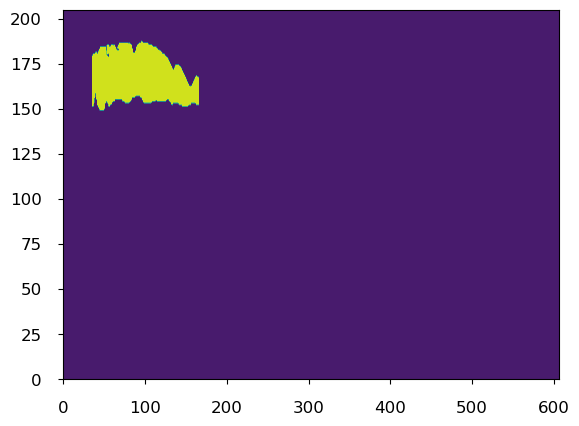

In [ ]:
# TEMPORARY - Plot section 9 mask to see what it looks like (checking section 9 masking)
plt.contourf(seabed_sec9_mask)

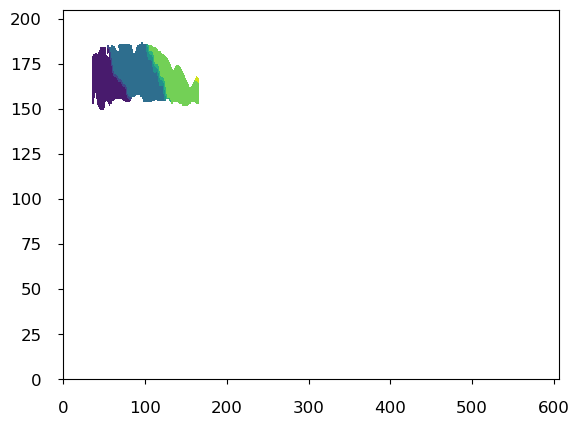

In [ ]:
# TEMPORARY (checking section 9 masking)
wave_frc = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Include/wave_forcing_file_kaktovik_shelf_cop_2020_data002.nc')
seabed_sec9_mask_nan = np.where(seabed_sec9_mask == 0, np.nan, seabed_sec9_mask)
Hwave_avg_masked = wave_frc.Hwave[100,:,:].values*temp_mask*seabed_sec9_mask_nan

plt.contourf(Hwave_avg_masked)


In [22]:
# Load in/prep model output/file paths/etc

# --- Aggregated ---
# ROMS aggregated output
# dbsed0001
file_names_agg = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_*.nc')

# Sort them to be in order
file_names_agg2 = sorted(file_names_agg)
# TEMP
#file_names_agg2 = file_names_agg2[:3]

# Check to see if this worked
print(file_names_agg2[0], flush=True)
#print(file_names_agg2[1], flush=True)
#print(file_names_agg2[2], flush=True)
print(file_names_agg2[-1], flush=True)

# Pull out the number of files
num_files_agg = len(file_names_agg2)

# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Aggregated 
full_time_len_agg, time_steps_agg, time_lengths_agg = get_model_time(file_names_agg2, num_files_agg)

# --- Unaggregated ---
# Same but for unagregated
# ROMS aggregated output
# dbsed0001
file_names_unag = glob('/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_*.nc')

# Sort them to be in order
file_names_unag2 = sorted(file_names_unag)

# Check to see if this worked
print(file_names_unag2[0], flush=True)
print(file_names_unag2[1], flush=True)
print(file_names_unag2[2], flush=True)
print(file_names_unag2[-1], flush=True)

# Pull out the number of files
num_files_unag = len(file_names_unag2)

# Pull out the length of time of the full run, the time steps, 
# and the length of time of each output file
# Unaggregated 
full_time_len_unag, time_steps_unag, time_lengths_unag = get_model_time(file_names_unag2, num_files_unag)


/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00001.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00019.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_00001.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_00002.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_00003.nc
/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_003_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_unaggregated_dbsed0001_00019.nc


In [15]:
file_names_agg

['/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00014.nc',
 '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00003.nc',
 '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00004.nc',
 '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00002.nc',
 '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00011.nc',
 '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_002_scratch/ocean_his_beaufort_rivers_10rivs_13seabed_aggregated_dbsed0001_00001.nc',
 '/scratch/alpine/brun1463/ROMS_scratch/Beaufort_Shelf_Rivers_Alpine_0

In [ ]:
# Get a spatial time series of total SSC - 
# both depth-integrated and depth-averaged
depth_int_ssc, depth_avg_ssc = get_timeseries_depth_int_avg_ssc_allsed(file_names_agg2, time_lengths_agg, full_time_len_agg, eta_rho_len, xi_rho_len)

In [23]:
# Load in the wave forcing file
wave_frc = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Include/wave_forcing_file_kaktovik_shelf_cop_2020_data002.nc')

In [24]:
# Make a version of the masks where they are nan instead of 0
# so that the averages aren't all 0s 
seabed_sec1_mask_nan = np.where(seabed_sec1_mask == 0, np.nan, seabed_sec1_mask)
seabed_sec2_mask_nan = np.where(seabed_sec2_mask == 0, np.nan, seabed_sec2_mask)
seabed_sec3_mask_nan = np.where(seabed_sec3_mask == 0, np.nan, seabed_sec3_mask)
seabed_sec4_mask_nan = np.where(seabed_sec4_mask == 0, np.nan, seabed_sec4_mask)
seabed_sec5_mask_nan = np.where(seabed_sec5_mask == 0, np.nan, seabed_sec5_mask)
seabed_sec6_mask_nan = np.where(seabed_sec6_mask == 0, np.nan, seabed_sec6_mask)
seabed_sec7_mask_nan = np.where(seabed_sec7_mask == 0, np.nan, seabed_sec7_mask)
seabed_sec8_mask_nan = np.where(seabed_sec8_mask == 0, np.nan, seabed_sec8_mask)
seabed_sec9_mask_nan = np.where(seabed_sec9_mask == 0, np.nan, seabed_sec9_mask)
seabed_sec10_mask_nan = np.where(seabed_sec10_mask == 0, np.nan, seabed_sec10_mask)
seabed_sec11_mask_nan = np.where(seabed_sec11_mask == 0, np.nan, seabed_sec11_mask)
seabed_sec12_mask_nan = np.where(seabed_sec12_mask == 0, np.nan, seabed_sec12_mask)
seabed_sec13_mask_nan = np.where(seabed_sec13_mask == 0, np.nan, seabed_sec13_mask)

In [ ]:
# Call the giant function above to get everything 
ssc_avg_masked, Hwave_avg_masked, bstr_avg_masked = get_time_series_ssc_waves_cur_bstr_by_section(file_names_agg2, wave_frc, full_time_len_agg, temp_mask, depth_int_ssc, regridder_u2rho, regridder_v2rho, seabed_sec1_mask_nan, seabed_sec2_mask_nan,
                                                                                                                          seabed_sec3_mask_nan, seabed_sec4_mask_nan, seabed_sec5_mask_nan, seabed_sec6_mask_nan,
                                                                                                                          seabed_sec7_mask_nan, seabed_sec8_mask_nan, seabed_sec9_mask_nan, seabed_sec10_mask_nan,
                                                                                                                          seabed_sec11_mask_nan, seabed_sec12_mask_nan, seabed_sec13_mask_nan)
                                                                                                
# cur_mag_1mab_masked, 

In [ ]:
# ---------------------------------------------------------------------------
# ---------------------- Save to a NetCDF -----------------------------------
# ---------------------------------------------------------------------------
# Assuming this all works, save the post-processed data to
# a netCDF just in case 

# Set up the data
roms_timeseries_ssc_hwave_curmag_bsrt_by_section = xr.Dataset(
    data_vars=dict(
        ssc_avg_by_section=(['ocean_time', 'section'], ssc_avg_masked),
        Hwave_avg_by_section=(['wave_time', 'section'], Hwave_avg_masked),
        #cur_mag_1mab_avg_by_section=(['ocean_time', 'section'], cur_mag_1mab_masked),
        bstr_avg_by_section=(['ocean_time', 'section'], bstr_avg_masked)
        ),
    coords=dict(
        ocean_time=('ocean_time', time_steps_agg),
        wave_time=('wave_time', wave_frc.wave_time.values),
        section=('section', np.arange(1,14,1))
        #eta_rho=('eta_rho', grid.eta_rho.values)
        ),
    attrs=dict(description='Time series of total depth-integrated SSC, Hwave, current magnitude 1 m above seabed (1 mab), and bed shear stress spatially-averaged over each section for the aggregated model runs')) 
# Add more metadata?
roms_timeseries_ssc_hwave_curmag_bsrt_by_section.ssc_avg_by_section.name='time series of depth-integrated SSC (total = all classes combined) (kg/m2) that is spatially-averaged over each shelf section'
roms_timeseries_ssc_hwave_curmag_bsrt_by_section.Hwave_avg_by_section.name='time series of significant wave height (m) that is spatially-averaged over each shelf section'
#roms_timeseries_ssc_hwave_curmag_bsrt_by_section.cur_mag_1mab_avg_by_section.name='time series of current magnitude 1 m above seabed (m/s) that is spatially-averaged over each shelf section'
roms_timeseries_ssc_hwave_curmag_bsrt_by_section.bstr_avg_by_section.name='time series of total bed shear stress (N/m2) that is spatially-averaged over each shelf section'

# Save to a netcdf
#roms_timeseries_ssc_hwave_curmag_bsrt_by_section.to_netcdf('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_hwave_curmag_bsrt_by_section_agg_TEST.nc')

print('Done saving to NetCDF', flush=True)

#### Plotting!

In [ ]:
# Convert wave time to datetime for plotting 
import datetime
reference_date = datetime.datetime(2000, 1, 1, 0, 0, 0) # January 1, 2000
wave_datetime = [reference_date + datetime.timedelta(seconds=s) 
                             for s in wave_frc.wave_time.values]


In [ ]:
# Read in post-processed data for plotting 
# Normal
# Aggregated 
time_series_data_agg = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_hwave_curmag_bsrt_by_section_agg.nc')
# Unaggregated 
time_series_data_unag = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_hwave_curmag_bsrt_by_section_unag.nc')
# Neglecting section 13
#time_series_data_agg = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_hwave_curmag_bsrt_by_section_agg_nosec13.nc')
# Unaggregated 
#time_series_data_unag = xr.open_dataset('/projects/brun1463/ROMS/Beaufort_Shelf_Rivers_Alpine_002/Scripts/Analysis/timeseries_ssc_hwave_curmag_bsrt_by_section_unag_nosec13.nc')


In [ ]:
time_series_data_agg

<xarray.Dataset> Size: 586kB
Dimensions:                      (ocean_time: 781, section: 13, wave_time: 3001)
Coordinates:
  * ocean_time                   (ocean_time) datetime64[ns] 6kB 2020-07-01T0...
  * wave_time                    (wave_time) float64 24kB 6.469e+08 ... 6.577...
  * section                      (section) int64 104B 1 2 3 4 5 ... 10 11 12 13
Data variables:
    ssc_avg_by_section           (ocean_time, section) float64 81kB ...
    Hwave_avg_by_section         (wave_time, section) float64 312kB ...
    cur_mag_1mab_avg_by_section  (ocean_time, section) float64 81kB ...
    bstr_avg_by_section          (ocean_time, section) float64 81kB ...
Attributes:
    description:  Time series of total depth-integrated SSC, Hwave, current m...

In [ ]:
# Assign variable names so the plots below work 
# Aggregated 
ssc_avg_masked_agg = time_series_data_agg.ssc_avg_by_section
Hwave_avg_masked_agg = time_series_data_agg.Hwave_avg_by_section
cur_avg_masked_agg = time_series_data_agg.cur_mag_1mab_avg_by_section
bstr_avg_masked_agg = time_series_data_agg.bstr_avg_by_section
# Unaggregated 
ssc_avg_masked_unag = time_series_data_unag.ssc_avg_by_section
Hwave_avg_masked_unag = time_series_data_unag.Hwave_avg_by_section
cur_avg_masked_unag = time_series_data_unag.cur_mag_1mab_avg_by_section
bstr_avg_masked_unag = time_series_data_unag.bstr_avg_by_section

**Aggregated Run Plots**

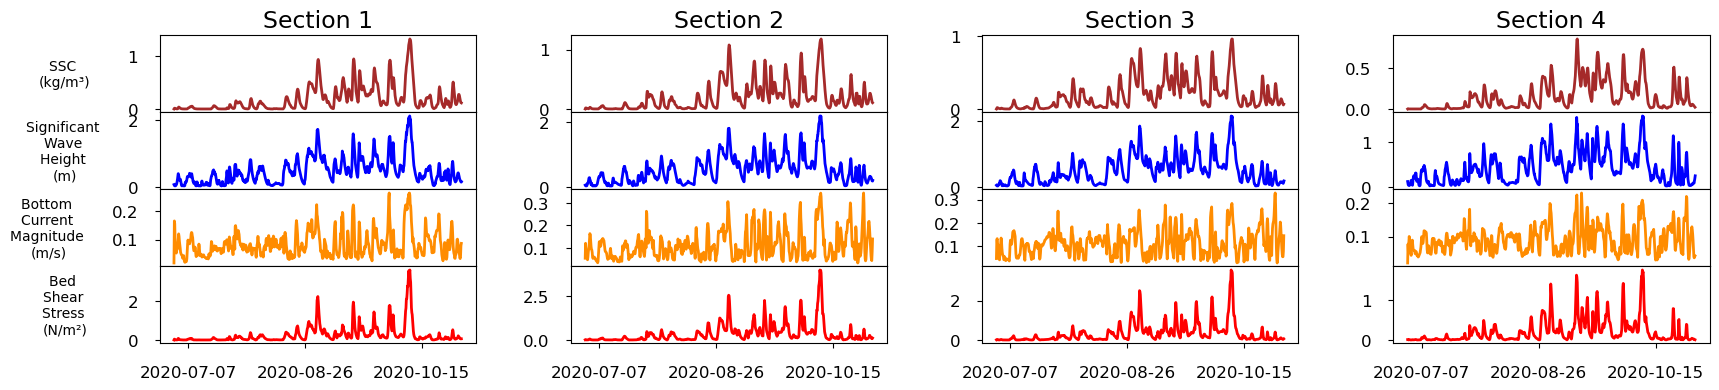

In [33]:
# Sections 1 - 4 

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 1 ---
ax[0,0].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,0], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,0], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,0], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,0], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 1', fontsize=fontsize-8)


# --- Section 2 ---
ax[0,1].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,1], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,1], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,1], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,1], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 2', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 3 ---
ax[0,2].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,2], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,2], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,2], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,2], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 3', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 4 ---
ax[0,3].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,3], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,3], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,3], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,3], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 4', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=45, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0, wspace=0.30)

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()


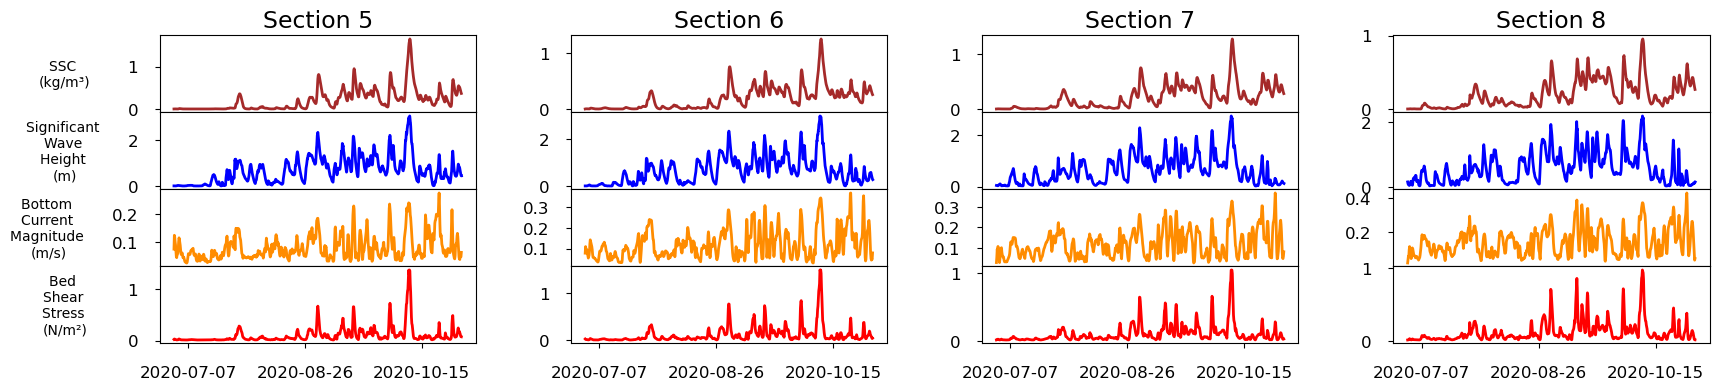

In [34]:
# Sections 5 - 8 

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 5 ---
ax[0,0].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,4], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,4], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,4], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,4], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 5', fontsize=fontsize-8)


# --- Section 6 ---
ax[0,1].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,5], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,5], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,5], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,5], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 6', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 7 ---
ax[0,2].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,6], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,6], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,6], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,6], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 7', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 8 ---
ax[0,3].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,7], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,7], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,7], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,7], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 8', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=45, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0, wspace=0.30)

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()


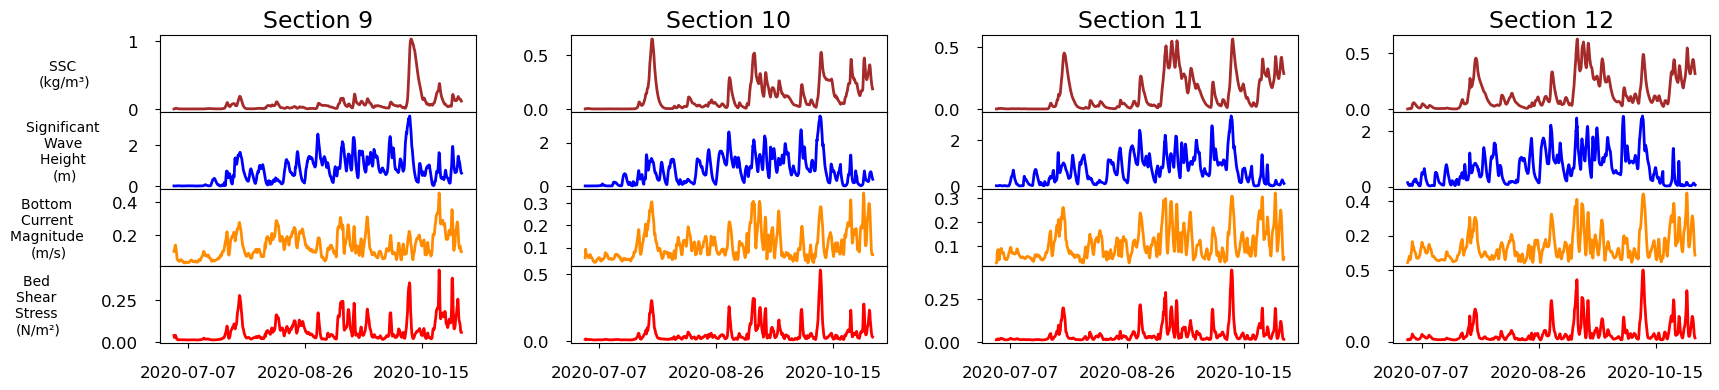

In [35]:
# Sections 9 - 12 

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 9 ---
ax[0,0].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,8], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,8], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,8], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,8], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 9', fontsize=fontsize-8)


# --- Section 10 ---
ax[0,1].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,9], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,9], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,9], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,9], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 10', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 11 ---
ax[0,2].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,10], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,10], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,10], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,10], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 11', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 12 ---
ax[0,3].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,11], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,11], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,11], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,11], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 12', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=45, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0, wspace=0.30)

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()


In [36]:
# Could plot Sections 1, 6, 8, 11 to match the paper; could also find all the correlations 
# and somehow communicate that in a table for all sections but plotting those sections probably makes 
# the most sense 

Text(0.736, 0.252, 'p)')

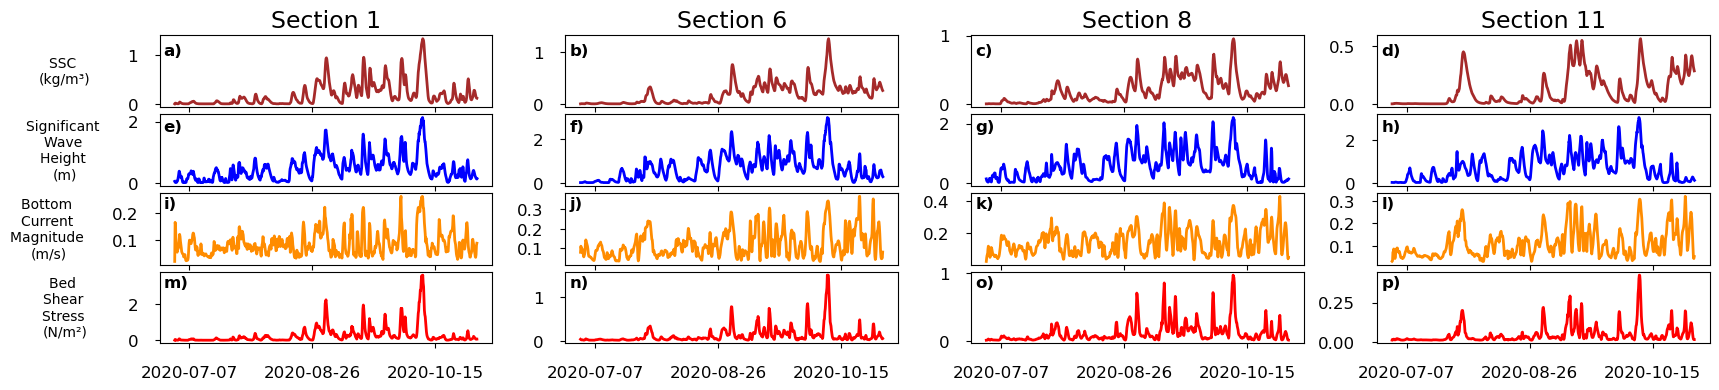

In [37]:
# Sections 1, 6, 8, 11

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 1 ---
ax[0,0].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,0], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,0], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,0], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,0], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 1', fontsize=fontsize-8)


# --- Section 6 ---
ax[0,1].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,5], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,5], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,5], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,5], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 6', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 8 ---
ax[0,2].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,7], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,7], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,7], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,7], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 8', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 11 ---
ax[0,3].plot(time_series_data_agg.ocean_time[:738], ssc_avg_masked_agg[:738,10], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,10], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_agg.ocean_time[:738], cur_avg_masked_agg[:738,10], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_agg.ocean_time[:738], bstr_avg_masked_agg[:738,10], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 11', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=45, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0.1, wspace=0.22)


# Add subplot labels
fig.text(0.127, 0.832, 'a)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.832, 'b)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.832, 'c)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.832, 'd)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.641, 'e)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.641, 'f)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.641, 'g)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.641, 'h)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.448, 'i)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.448, 'j)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.448, 'k)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.448, 'l)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.252, 'm)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.252, 'n)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.252, 'o)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.252, 'p)', color='black', fontsize=fontsize-13, weight='bold')

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()


**Unaggregated**

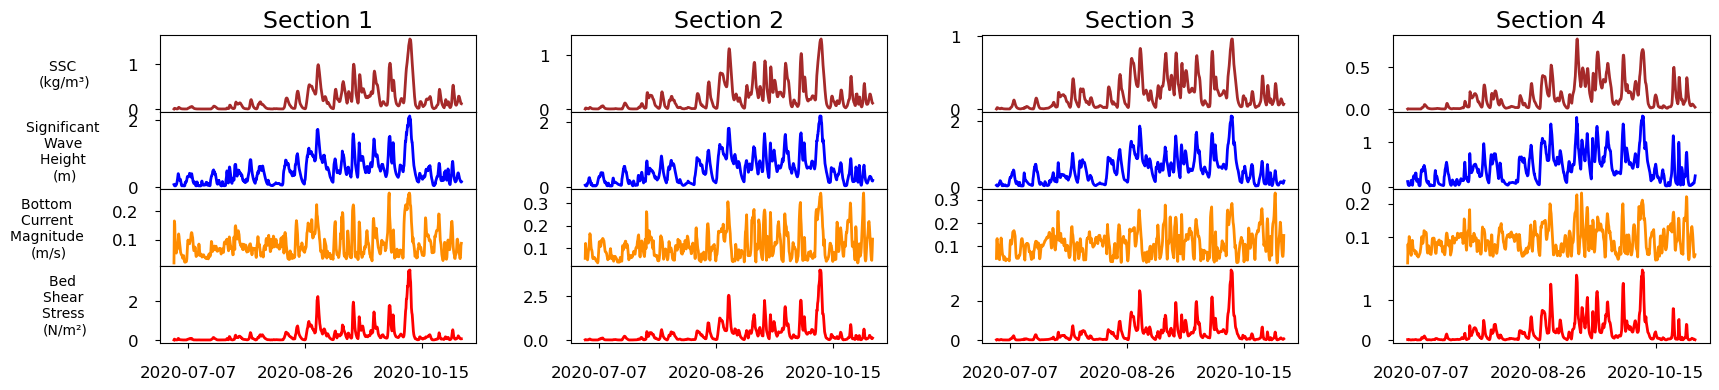

In [38]:
# Sections 1 - 4 

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 1 ---
ax[0,0].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,0], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,0], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,0], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,0], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 1', fontsize=fontsize-8)


# --- Section 2 ---
ax[0,1].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,1], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,1], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,1], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,1], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 2', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 3 ---
ax[0,2].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,2], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,2], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,2], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,2], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 3', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 4 ---
ax[0,3].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,3], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,3], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,3], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,3], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 4', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=45, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0, wspace=0.30)

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()


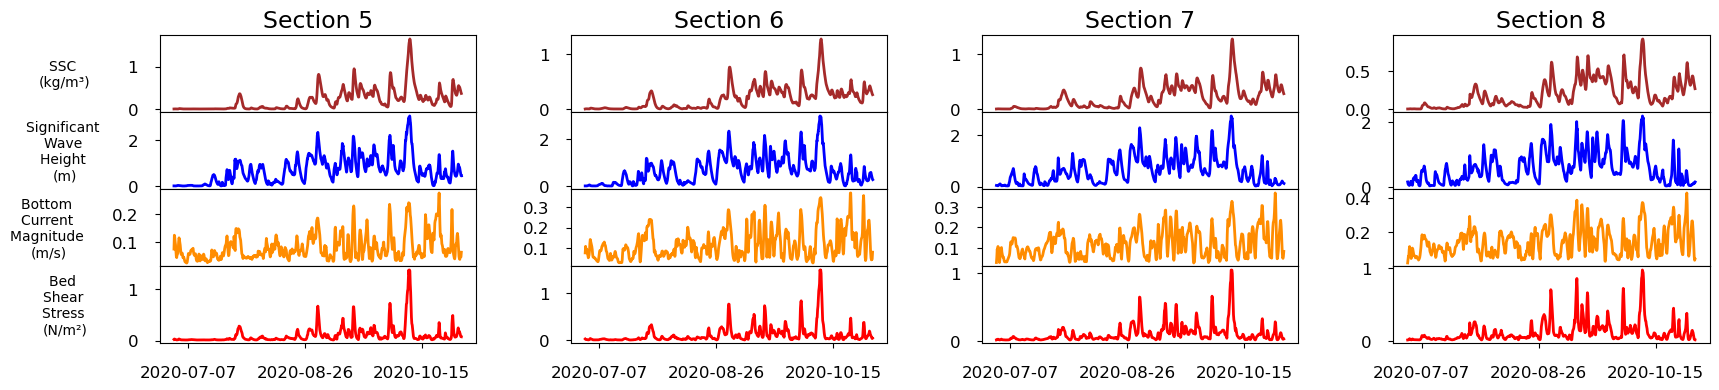

In [39]:
# Sections 5 - 8 

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 5 ---
ax[0,0].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,4], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,4], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,4], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,4], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 5', fontsize=fontsize-8)


# --- Section 6 ---
ax[0,1].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,5], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,5], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,5], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,5], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 6', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 7 ---
ax[0,2].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,6], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,6], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,6], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,6], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 7', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 8 ---
ax[0,3].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,7], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,7], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,7], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,7], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 8', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=45, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0, wspace=0.30)

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()

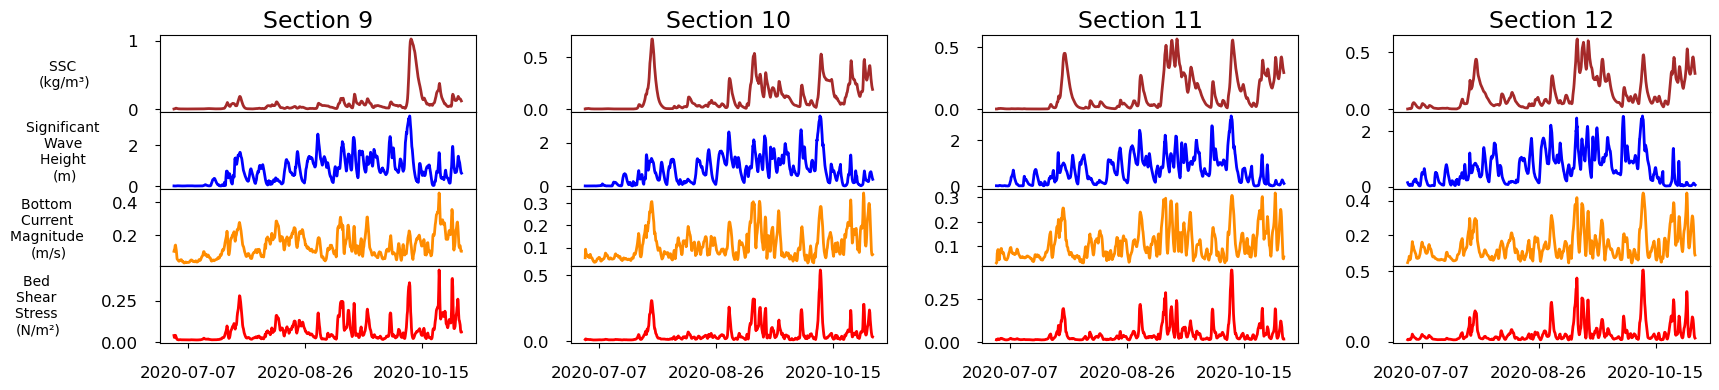

In [40]:
# Sections 9 - 12 

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 9 ---
ax[0,0].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,8], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,8], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,8], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,8], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 9', fontsize=fontsize-8)


# --- Section 10 ---
ax[0,1].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,9], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,9], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,9], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,9], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 10', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 11 ---
ax[0,2].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,10], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,10], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,10], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,10], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 11', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 12 ---
ax[0,3].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,11], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,11], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,11], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,11], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 12', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=45, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0, wspace=0.30)

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()

Text(0.736, 0.252, 'p)')

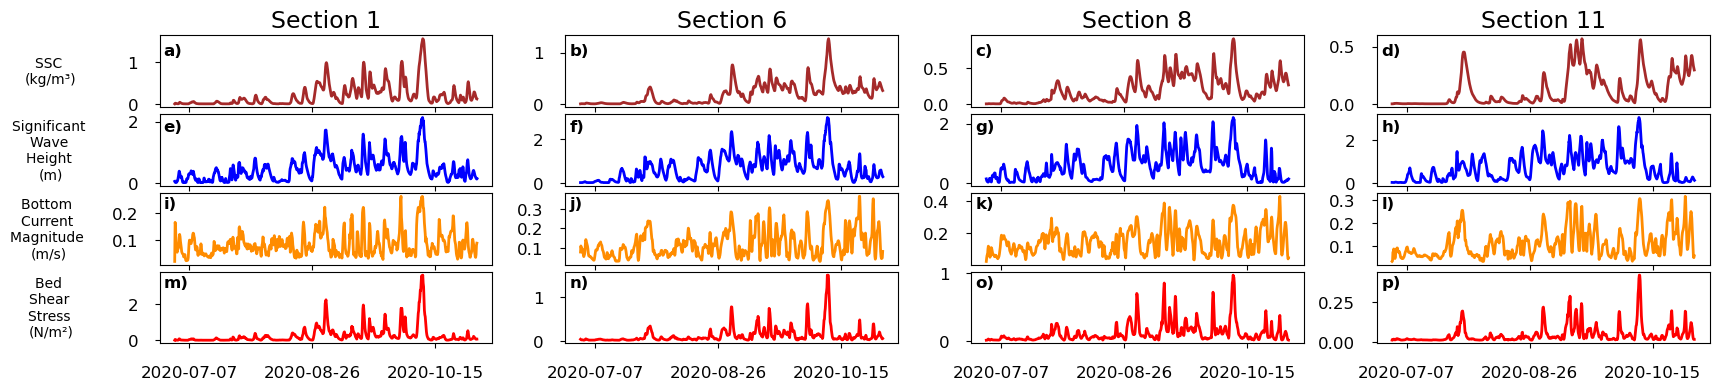

In [41]:
# Sections 1, 6, 8, 11

# Plot four sections at a time
fig, ax = plt.subplots(4, 4, figsize=(20,4), )

# --- Section 1 ---
ax[0,0].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,0], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,0], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,0], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,0], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')

# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 1', fontsize=fontsize-8)


# --- Section 6 ---
ax[0,1].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,5], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,5], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,5], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,5], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 6', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 8 ---
ax[0,2].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,7], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,2].plot(wave_datetime[:-50], Hwave_avg_masked_agg[:-50,7], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,7], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,2].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,7], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
ax[3,2].sharex(ax[0,2])
plt.setp(ax[0,2].get_xticklabels(), visible=False)
plt.setp(ax[1,2].get_xticklabels(), visible=False)
plt.setp(ax[2,2].get_xticklabels(), visible=False)
# Label the axes
ax[0,2].set_title('Section 8', fontsize=fontsize-8)
#fig.subplots_adjust(hspace=0)


# --- Section 11 ---
ax[0,3].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,10], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,3].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,10], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,10], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,3].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,10], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
ax[3,3].sharex(ax[0,3])
plt.setp(ax[0,3].get_xticklabels(), visible=False)
plt.setp(ax[1,3].get_xticklabels(), visible=False)
plt.setp(ax[2,3].get_xticklabels(), visible=False)
# Label the axes
ax[0,3].set_title('Section 11', fontsize=fontsize-8) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)

# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=55, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=55, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=45, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=55, va='center')

# Set the maximum number of x tixk labels
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(3))
ax[3,3].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0.1, wspace=0.22)

# Set y limits to be the same for all - makes it harder to see correlations
# # SSC
# ax[0,0].set_ylim(0,1.7)
# ax[0,1].set_ylim(0,1.7)
# ax[0,2].set_ylim(0,1.7)
# ax[0,3].set_ylim(0,1.7)
# # Hwave
# ax[1,0].set_ylim(0,3.1)
# ax[1,1].set_ylim(0,3.1)
# ax[1,2].set_ylim(0,3.1)
# ax[1,3].set_ylim(0,3.1)
# # Bot cur mag
# ax[2,0].set_ylim(0,0.45)
# ax[2,1].set_ylim(0,0.45)
# ax[2,2].set_ylim(0,0.45)
# ax[2,3].set_ylim(0,0.45)
# # bstr
# ax[3,0].set_ylim(0,3.7)
# ax[3,1].set_ylim(0,3.7)
# ax[3,2].set_ylim(0,3.7)
# ax[3,3].set_ylim(0,3.7)

# Add subplot labels
fig.text(0.127, 0.832, 'a)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.832, 'b)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.832, 'c)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.832, 'd)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.641, 'e)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.641, 'f)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.641, 'g)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.641, 'h)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.448, 'i)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.448, 'j)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.448, 'k)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.448, 'l)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.252, 'm)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.330, 0.252, 'n)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.533, 0.252, 'o)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.736, 0.252, 'p)', color='black', fontsize=fontsize-13, weight='bold')

# # Add legends on first subplot
# ax[0,0].legend() # fontsize=fontsize-10
# ax[1,0].legend()
# ax[2,0].legend()
# ax[3,0].legend()

#### Stats!

In [42]:
# Calculate correlations for each section between SSC, significant 
# wave height, bottom current magnitude, and bed shear stress 



In [43]:
# Make a function to get the correlation coefficients for 
# each section so it can just be called and return the correlation
def get_correlations(ssc_timeseries, hwave_timeseries, botcurmag_timeseries, bstr_timeseries):
    """ 
    The purpose of this function is to take given time series and find their correlation  
    with the SSC time series. 

    Inputs:
    - ssc_timeseries: A time series of depth-integrated SSC average over different sections of the domain [ocean_time, section]
    - hwave_timeseries: A time series of significant wave height averaged over different sections of the domain [wave_time, section]
    - botcurmag_timeseries: A time series of bottom current magnitude (1 m above seafloor) averaged over different sections of the domain [ocean_time, section]
    - bstr_timeseries: A time series of bstrcwmax averaged over different sections of the domain [ocean_time, section]

    Outputs:
    - hwave_corr_with_ssc: Array containing pearson r correlation coefficient 
                           and p-value for significant wave height compared to SSC [2, section]; 
                           first value is correlation coefficient, second is p-value
    - botcurmag_corr_with_ssc: Array containing pearson r correlation coefficient 
                           and p-value for bottom current magnitude (1 mab) compared to SSC [2, section]; 
                           first value is correlation coefficient, second is p-value
    - bstr_corr_with_ssc: Array containing pearson r correlation coefficient 
                           and p-value for bstrcwmax compared to SSC [2, section]; 
                           first value is correlation coefficient, second is p-value

    """
    from scipy import stats

    # Get the number of seabed sections 
    num_sections = len(ssc_timeseries[0,:])
    print('num_sections: ', num_sections, flush=True)

    # Make empty arrays to hold the correlations 
    hwave_corr_with_ssc = np.empty((2, num_sections))
    botcurmag_corr_with_ssc = np.empty((2, num_sections))
    bstr_corr_with_ssc = np.empty((2, num_sections))

    # Loop through the sections to find correlations
    for s in range(num_sections):
        # Resample wave data to match frequency of SSC for plotting 
        # Resample wave data to be 4 hourly to match
        hourly_hwave = pd.Series(hwave_timeseries[:-50,s], index=wave_datetime[:-50])
        four_hourly_hwave = hourly_hwave.resample('4H').mean()
        
        # Find the correlations and save to the arrays
        # First value is the pearson r correlation coefficient
        # Second value is the p-value
        hwave_corr_tmp, hwave_pval_tmp = stats.pearsonr(ssc_timeseries[:,s], four_hourly_hwave[:])
        botcur_corr_tmp, botcur_pval_tmp = stats.pearsonr(ssc_timeseries[:,s], botcurmag_timeseries[:,s])
        bstr_corr_tmp, bstr_pval_tmp = stats.pearsonr(ssc_timeseries[:,s], bstr_timeseries[:,s])

        # Save these to the arrays 
        hwave_corr_with_ssc[0,s] = hwave_corr_tmp
        hwave_corr_with_ssc[1,s] = hwave_pval_tmp
        botcurmag_corr_with_ssc[0,s] = botcur_corr_tmp
        botcurmag_corr_with_ssc[1,s] = botcur_pval_tmp
        bstr_corr_with_ssc[0,s] = bstr_corr_tmp
        bstr_corr_with_ssc[1,s] = bstr_pval_tmp
        

    # Return the arrays with these stats 
    return(hwave_corr_with_ssc, botcurmag_corr_with_ssc, bstr_corr_with_ssc)



In [44]:
# Call the function to get some stats
# Aggregated 
Hwave_corr_agg, botcur_corr_agg, bstr_corr_agg = get_correlations(ssc_avg_masked_agg[:738,:], Hwave_avg_masked_agg, cur_avg_masked_agg[:738,:], bstr_avg_masked_agg[:738,:])
# Unaggregated 
Hwave_corr_unag, botcur_corr_unag, bstr_corr_unag = get_correlations(ssc_avg_masked_unag[:738,:], Hwave_avg_masked_unag, cur_avg_masked_unag[:738,:], bstr_avg_masked_unag[:738,:])


num_sections:  13
num_sections:  13


/projects/brun1463/code-server/tmp/ipykernel_2461987/3523299860.py:42: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  four_hourly_hwave = hourly_hwave.resample('4H').mean()


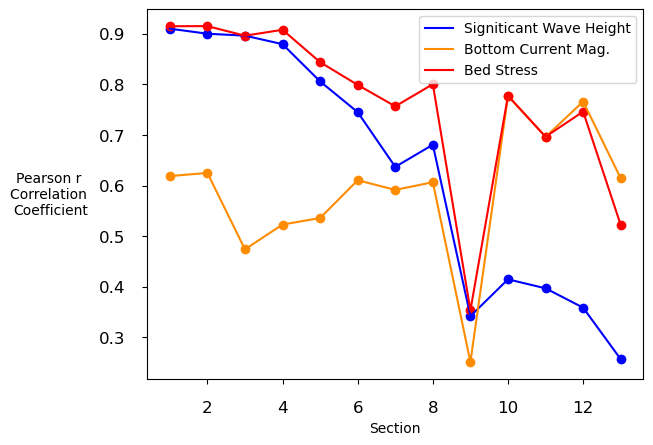

In [45]:
# Plot these correlations? By section? just so I can see them
# Aggregated 
fig, ax = plt.subplots()
sections = np.arange(1,14,1)

ax.plot(sections, Hwave_corr_agg[0,:], label='Signiticant Wave Height', color='blue')
ax.plot(sections, botcur_corr_agg[0,:], label='Bottom Current Mag.', color='darkorange')
ax.plot(sections, bstr_corr_agg[0,:], label='Bed Stress', color='red')
ax.scatter(sections, Hwave_corr_agg[0,:], color='blue')
ax.scatter(sections, botcur_corr_agg[0,:], color='darkorange')
ax.scatter(sections, bstr_corr_agg[0,:], color='red')

ax.set_xlabel('Section')
ax.set_ylabel('Pearson r \nCorrelation \nCoefficient', va='center', rotation=0, labelpad=35)
ax.legend()

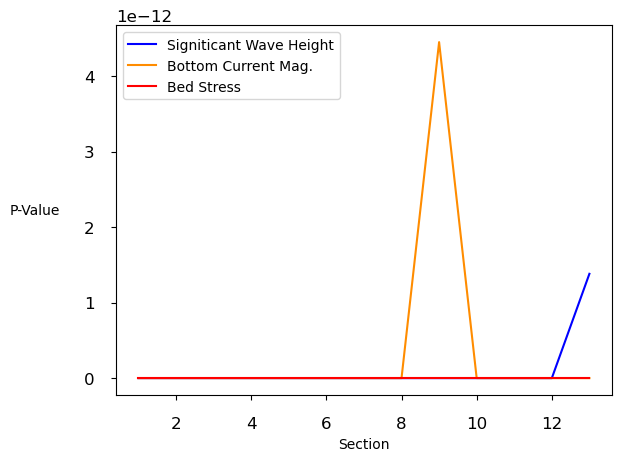

In [46]:
# Plot these correlations? By section? just so I can see them
# Aggregated 
fig, ax = plt.subplots()
sections = np.arange(1,14,1)

ax.plot(sections, Hwave_corr_agg[1,:], label='Signiticant Wave Height', color='blue')
ax.plot(sections, botcur_corr_agg[1,:], label='Bottom Current Mag.', color='darkorange')
ax.plot(sections, bstr_corr_agg[1,:], label='Bed Stress', color='red')

ax.set_xlabel('Section')
ax.set_ylabel('P-Value', va='center', rotation=0, labelpad=35)
ax.legend()

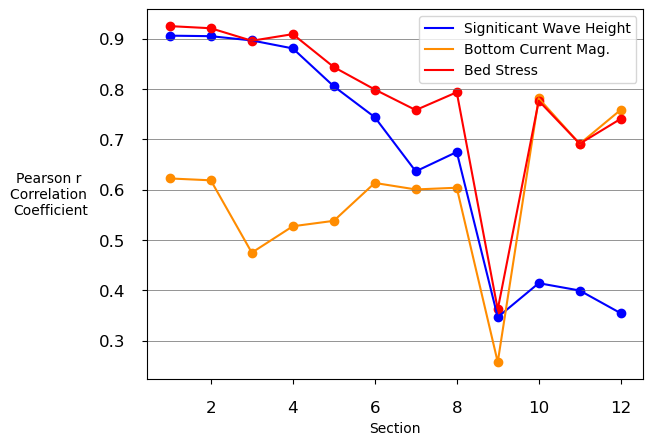

In [47]:
# Plot these correlations? By section? just so I can see them
# Unaggregated 
fig, ax = plt.subplots()
sections = np.arange(1,13,1)

# Add horizontal lines for factors of 10
ax.axhline(y=0.3, color='dimgray', linewidth=0.5)
ax.axhline(y=0.4, color='dimgray', linewidth=0.5)
ax.axhline(y=0.5, color='dimgray', linewidth=0.5)
ax.axhline(y=0.6, color='dimgray', linewidth=0.5)
ax.axhline(y=0.7, color='dimgray', linewidth=0.5)
ax.axhline(y=0.8, color='dimgray', linewidth=0.5)
ax.axhline(y=0.9, color='dimgray', linewidth=0.5)


ax.plot(sections, Hwave_corr_unag[0,:-1], label='Signiticant Wave Height', color='blue')
ax.plot(sections, botcur_corr_unag[0,:-1], label='Bottom Current Mag.', color='darkorange')
ax.plot(sections, bstr_corr_unag[0,:-1], label='Bed Stress', color='red')
ax.scatter(sections, Hwave_corr_unag[0,:-1], color='blue')
ax.scatter(sections, botcur_corr_unag[0,:-1], color='darkorange')
ax.scatter(sections, bstr_corr_unag[0,:-1], color='red')

ax.set_xlabel('Section')
ax.set_ylabel('Pearson r \nCorrelation \nCoefficient', va='center', rotation=0, labelpad=35)
ax.legend()

In [48]:
print('Hwave: ', Hwave_corr_unag[0,:-1])
print('\nbotcur: ', botcur_corr_unag[0,:-1])
print('\nbstr: ', bstr_corr_unag[0,:-1])

Hwave:  [0.9057842  0.90475316 0.89629204 0.88045489 0.80523438 0.74392747
 0.63638504 0.6748275  0.34692369 0.41440846 0.39980376 0.35472134]

botcur:  [0.62230187 0.61859763 0.47495463 0.52739079 0.53817691 0.61339175
 0.60046984 0.60388376 0.25767854 0.78133366 0.69100855 0.7585595 ]

bstr:  [0.92472999 0.92050816 0.89564003 0.90880554 0.84345144 0.79887074
 0.75804095 0.79345341 0.36224573 0.77643313 0.69120724 0.74069243]


In [49]:
print('Hwave: ', Hwave_corr_unag[0,:6])

Hwave:  [0.9057842  0.90475316 0.89629204 0.88045489 0.80523438 0.74392747]


In [50]:
# Get the average correlation with Hwave for sections 1 - 6
print('Hwave_cor_avg_1_6: ', np.mean(Hwave_corr_unag[0,:6]))

Hwave_cor_avg_1_6:  0.8560743580797195


In [51]:
# Get the average correlation with bstr for section 10, 11, 12
print('botcur: ', botcur_corr_unag[0,-4:-1])
print('botcur_cor_avg_10_12: ', np.mean(botcur_corr_unag[0,-4:-1]))

botcur:  [0.78133366 0.69100855 0.7585595 ]
botcur_cor_avg_10_12:  0.743633905378764


Text(0.89, 0.655, 'i)')

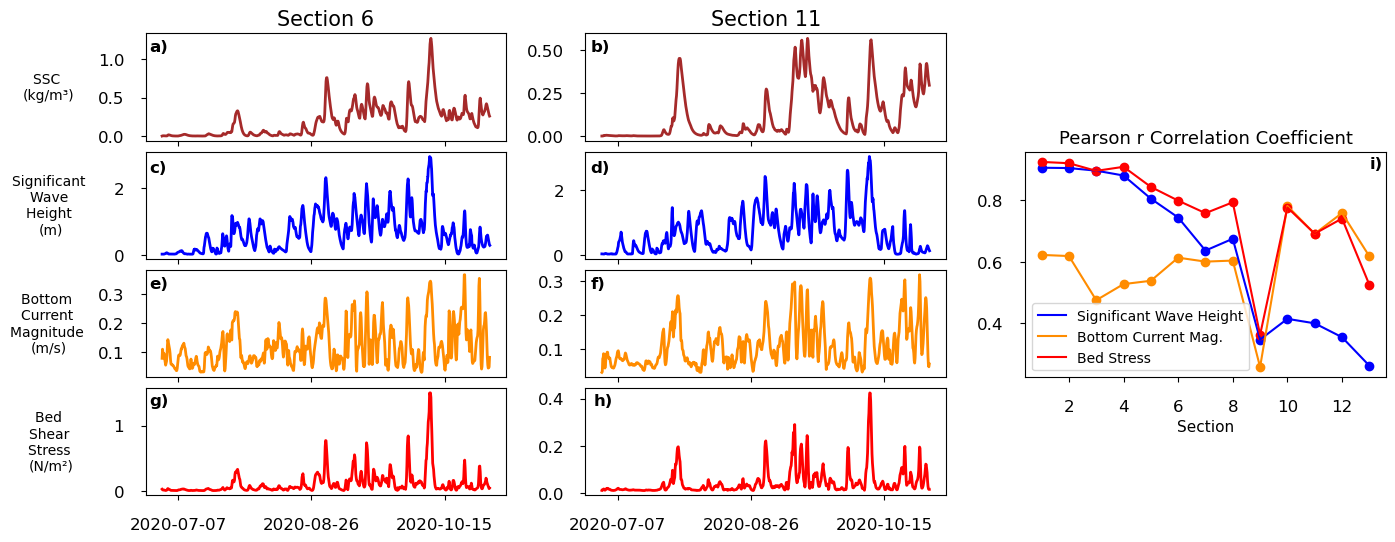

In [52]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec

# Create figure and a flexible grid
fig = plt.figure(figsize=(16,6))
gs = GridSpec(4, 3, figure=fig, width_ratios=[1,1,1])

# First column: one large subplot spanning all 4 rows
ax_big = fig.add_subplot(gs[1:3, 2])   # <--- spans rows 0–3

# Other subplots
ax = np.empty((4,3), dtype=object)
ax[:,2] = ax_big    # assign big axes for compatibility with your code

# Create the remaining axes normally
for r in range(4):
    for c in range(0,2):
        ax[r,c] = fig.add_subplot(gs[r, c])


sections = np.arange(1,14,1)
ax_big.plot(sections, Hwave_corr_unag[0,:], label='Significant Wave Height', color='blue')
ax_big.plot(sections, botcur_corr_unag[0,:], label='Bottom Current Mag.', color='darkorange')
ax_big.plot(sections, bstr_corr_unag[0,:], label='Bed Stress', color='red')
ax_big.scatter(sections, Hwave_corr_unag[0,:], color='blue')
ax_big.scatter(sections, botcur_corr_unag[0,:], color='darkorange')
ax_big.scatter(sections, bstr_corr_unag[0,:], color='red')

ax_big.set_xlabel('Section', fontsize=fontsize-14)
ax_big.set_title('Pearson r Correlation Coefficient', fontsize=fontsize-12)
ax_big.legend()


# Plot section 6 
# --- Section 6 ---
ax[0,0].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,5], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,0].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,5], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,5], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,0].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,5], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
ax[3,0].sharex(ax[0,0])
plt.setp(ax[0,0].get_xticklabels(), visible=False)
plt.setp(ax[1,0].get_xticklabels(), visible=False)
plt.setp(ax[2,0].get_xticklabels(), visible=False)
# Label the axes
ax[0,0].set_title('Section 6', fontsize=fontsize-10)
#fig.subplots_adjust(hspace=0)


# Plot section 11
# --- Section 11 ---
ax[0,1].plot(time_series_data_unag.ocean_time[:738], ssc_avg_masked_unag[:738,10], linewidth=2, color='brown', label='SSC (kg/m\u00b3)')
ax[1,1].plot(wave_datetime[:-50], Hwave_avg_masked_unag[:-50,10], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_series_data_unag.ocean_time[:738], cur_avg_masked_unag[:738,10], linewidth=2, color='darkorange', label='Current Magnitude (m/s)')
ax[3,1].plot(time_series_data_unag.ocean_time[:738], bstr_avg_masked_unag[:738,10], linewidth=2, color='red', label='Bed Shear Stress (N/m\u00b2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
ax[3,1].sharex(ax[0,1])
plt.setp(ax[0,1].get_xticklabels(), visible=False)
plt.setp(ax[1,1].get_xticklabels(), visible=False)
plt.setp(ax[2,1].get_xticklabels(), visible=False)
# Label the axes
ax[0,1].set_title('Section 11', fontsize=fontsize-10) # fontsize=fontsize-5
#fig.subplots_adjust(hspace=0)


# Label y-axes
ax[0,0].set_ylabel('SSC \n(kg/m\u00b3)', rotation=0, labelpad=35, va='center')
ax[1,0].set_ylabel('Significant \nWave \nHeight \n(m)', rotation=0, labelpad=45, va='center')
ax[2,0].set_ylabel('Bottom \nCurrent \nMagnitude \n(m/s)', rotation=0, labelpad=35, va='center')
ax[3,0].set_ylabel('Bed \nShear \nStress \n(N/m\u00b2)', rotation=0, labelpad=45, va='center')

# Set the maximum number of x tixk labels
ax[3,1].xaxis.set_major_locator(MaxNLocator(3))
ax[3,2].xaxis.set_major_locator(MaxNLocator(8))
ax[3,0].xaxis.set_major_locator(MaxNLocator(3))

# Set subplot spacing 
fig.subplots_adjust(hspace=0.1, wspace=0.22)


# Add subplot labels
fig.text(0.127, 0.850, 'a)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.403, 0.850, 'b)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.649, 'c)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.403, 0.649, 'd)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.456, 'e)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.403, 0.456, 'f)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.127, 0.261, 'g)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.405, 0.261, 'h)', color='black', fontsize=fontsize-13, weight='bold')
fig.text(0.890, 0.655, 'i)', color='black', fontsize=fontsize-13, weight='bold')


In [53]:
# Edit previous functions to just get section 13
# Make a function to calculate the depth-integrated SSC and 
# depth-averaged SSC for all sediment class
def calc_depth_int_avg_ssc_1sed(filename, sed_class):
    """
    The purpose of this function is to take a given model output file, load 
    in the output, and caluclate the depth-integrated and depth-averaegd 
    suspended sediment concentrations (SSC) for section 13 sediments 

    Parameters
    ----------
    filename : The name/path of the model output file.

    Returns
    -------
    depth_int_ssc_allsed: Spatail time series of depth-integrated SSC for 
    all sediment classes (kg/m2)
    depth_avg_ssc_allsed: Spatial time series of depth-averaged ssc for a 
    all sediment classes (kg/m3)

    """
    
    # Load in the model output
    model_output = xr.open_dataset(filename)
    
    # Pull out the sediment class of interest
    #ssc_1sed_tmp = (model_output.mud_14)
    ssc_1sed_tmp = model_output[sed_class]
    
    # To collapse to horizontal, multiply each layer by its
    # thickness
    # Calculate the time-varying thickness of the cells
    dz = abs(model_output.z_w[:,:-1,:,:].values - model_output.z_w[:,1:,:,:].values)
    
    # Calculate depth-integrated ssc
    depth_int_ssc_1sed = (((ssc_1sed_tmp*dz)).sum(dim='s_rho'))
    
    # Divide by bathymetry to get depth-averaged SSC (kg/m3)
    depth_avg_ssc_1sed = depth_int_ssc_1sed/model_output.bath[:,:,:].values
    
    # Return the depth-integrated u flux for all sediment classes
    return(depth_int_ssc_1sed, depth_avg_ssc_1sed)


# Make a function that does everything that is done below for a given sediment class
def get_timeseries_depth_int_avg_ssc_1sed(file_names, sed_class, time_lengths, full_time_len, eta_rho_len, xi_rho_len):
    """
    The purpose of this function is to get out two time series of the kg of sediment 
    per layer in the seabed and the frac of sediment per layer in the seabed for 
    a given sediment class (total SSC)
    

    Parameters
    ----------
    file_names : list of path and names of model outputs
    time_lengths : List of lengths of time in each output file 
    full_time_len : Lenght of time of all model output
    eta_rho_len : Length of eta_rho points
    xi_rho_len : Length of xi_rho points

    Returns
    -------
    None.

    """
    
    # Make empty arrays to hold the time series
    depth_int_ssc_1sed = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    depth_avg_ssc_1sed = np.empty((full_time_len, eta_rho_len, xi_rho_len))
    
    #
    # Set a time step to track which time step the loop is on
    time_step = 0

    # Get number of files
    num_files = len(file_names)

    # Loop through the model output
    for j in range(num_files):
    #for j in range(1):

        print('j: ', j, flush=True)
        
        # Prep time for saving to arrays
        #print('time_step: ', time_step)
        #print('time_step + time_lengths[j]: ', time_step+time_lengths[j])
        start = int(time_step)
        end = int(time_step+time_lengths[j])
        
        # Call the function to process the output - mass in seabed
        depth_int_ssc_1sed[start:end,:,:], depth_avg_ssc_1sed[start:end,:,:] = calc_depth_int_avg_ssc_1sed(file_names[j], sed_class)
        
        # Update the base time_step
        time_step = time_step + time_lengths[j]
    
    # Return these arrays 
    return(depth_int_ssc_1sed, depth_avg_ssc_1sed)

In [37]:
# Call the edited functions
# Aggregated
depth_int_ssc_agg_sec13, depth_avg_ssc_agg_sec13 = get_timeseries_depth_int_avg_ssc_1sed(file_names_agg2, 'mud_14', time_lengths_agg, full_time_len_agg, eta_rho_len, xi_rho_len)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18


In [43]:
# Same but for section 10
depth_int_ssc_agg_sec10, depth_avg_ssc_agg_sec10 = get_timeseries_depth_int_avg_ssc_1sed(file_names_agg2, 'mud_11', time_lengths_agg, full_time_len_agg, eta_rho_len, xi_rho_len)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18


In [44]:
# Same but for section 5
depth_int_ssc_agg_sec5, depth_avg_ssc_agg_sec5 = get_timeseries_depth_int_avg_ssc_1sed(file_names_agg2, 'mud_06', time_lengths_agg, full_time_len_agg, eta_rho_len, xi_rho_len)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18


In [45]:
# Then mask over time to just section 9, summ all space for all times, then correlate this with total ssc in section 9
# Loop through time and multiply by mask for section 9
depth_int_ssc_agg_sec13_in_sec9 = np.empty_like(depth_int_ssc_agg_sec13)
depth_int_ssc_agg_sec10_in_sec9 = np.empty_like(depth_int_ssc_agg_sec13)
depth_int_ssc_agg_sec5_in_sec9 = np.empty_like(depth_int_ssc_agg_sec13)
for ttt in range(full_time_len_agg):
    depth_int_ssc_agg_sec13_in_sec9[ttt,:,:] = depth_int_ssc_agg_sec13[ttt,:,:]*seabed_sec9_mask_nan*temp_mask
    depth_int_ssc_agg_sec10_in_sec9[ttt,:,:] = depth_int_ssc_agg_sec10[ttt,:,:]*seabed_sec9_mask_nan*temp_mask
    depth_int_ssc_agg_sec5_in_sec9[ttt,:,:] = depth_int_ssc_agg_sec5[ttt,:,:]*seabed_sec9_mask_nan*temp_mask

In [46]:
depth_int_ssc_agg_sec13_in_sec9

array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       ...,

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan

In [47]:
# Sum over space
depth_int_ssc_agg_sec13_in_sec9_sum = np.nansum(depth_int_ssc_agg_sec13_in_sec9, axis=(1,2))
depth_int_ssc_agg_sec10_in_sec9_sum = np.nansum(depth_int_ssc_agg_sec10_in_sec9, axis=(1,2))
depth_int_ssc_agg_sec5_in_sec9_sum = np.nansum(depth_int_ssc_agg_sec5_in_sec9, axis=(1,2))

In [49]:
# Get the correlations
from scipy import stats
sec13_corr_agg_tmp, sec13_pval_agg_tmp = stats.pearsonr(ssc_avg_masked_agg[:738,10], depth_int_ssc_agg_sec13_in_sec9_sum[:738])
print('correlation between sed 13 agg in 9 and total ssc in 9: ', sec13_corr_agg_tmp)
sec10_corr_agg_tmp, sec10_pval_agg_tmp = stats.pearsonr(ssc_avg_masked_agg[:738,10], depth_int_ssc_agg_sec10_in_sec9_sum[:738])
print('correlation between sed 10 agg in 9 and total ssc in 9: ', sec10_corr_agg_tmp)
sec5_corr_agg_tmp, sec5_pval_agg_tmp = stats.pearsonr(ssc_avg_masked_agg[:738,10], depth_int_ssc_agg_sec5_in_sec9_sum[:738])
print('correlation between sed 5 agg in 9 and total ssc in 9: ', sec5_corr_agg_tmp)

correlation between sed 13 agg in 9 and total ssc in 9:  0.412355509798536
correlation between sed 10 agg in 9 and total ssc in 9:  0.3136574751442684
correlation between sed 5 agg in 9 and total ssc in 9:  0.41107776247225536


In [54]:
# Do this all again for unaggregated 
# Unaggregated
depth_int_ssc_unag_sec13, depth_avg_ssc_unag_sec13 = get_timeseries_depth_int_avg_ssc_1sed(file_names_unag2, 'mud_14', time_lengths_unag, full_time_len_unag, eta_rho_len, xi_rho_len)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18


In [55]:
# Same but for section 10
depth_int_ssc_unag_sec10, depth_avg_ssc_unag_sec10 = get_timeseries_depth_int_avg_ssc_1sed(file_names_unag2, 'mud_11', time_lengths_unag, full_time_len_unag, eta_rho_len, xi_rho_len)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18


In [56]:
# Same but for section 5
depth_int_ssc_unag_sec5, depth_avg_ssc_unag_sec5 = get_timeseries_depth_int_avg_ssc_1sed(file_names_unag2, 'mud_06', time_lengths_unag, full_time_len_unag, eta_rho_len, xi_rho_len)

j:  0
j:  1
j:  2
j:  3
j:  4
j:  5
j:  6
j:  7
j:  8
j:  9
j:  10
j:  11
j:  12
j:  13
j:  14
j:  15
j:  16
j:  17
j:  18


In [57]:
# Then mask over time to just section 9, summ all space for all times, then correlate this with total ssc in section 9
# Loop through time and multiply by mask for section 9
depth_int_ssc_unag_sec13_in_sec9 = np.empty_like(depth_int_ssc_unag_sec13)
depth_int_ssc_unag_sec10_in_sec9 = np.empty_like(depth_int_ssc_unag_sec13)
depth_int_ssc_unag_sec5_in_sec9 = np.empty_like(depth_int_ssc_unag_sec13)
for ttt in range(full_time_len_unag):
    depth_int_ssc_unag_sec13_in_sec9[ttt,:,:] = depth_int_ssc_unag_sec13[ttt,:,:]*seabed_sec9_mask_nan*temp_mask
    depth_int_ssc_unag_sec10_in_sec9[ttt,:,:] = depth_int_ssc_unag_sec10[ttt,:,:]*seabed_sec9_mask_nan*temp_mask
    depth_int_ssc_unag_sec5_in_sec9[ttt,:,:] = depth_int_ssc_unag_sec5[ttt,:,:]*seabed_sec9_mask_nan*temp_mask

In [58]:
# Sum over space
depth_int_ssc_unag_sec13_in_sec9_sum = np.nansum(depth_int_ssc_unag_sec13_in_sec9, axis=(1,2))
depth_int_ssc_unag_sec10_in_sec9_sum = np.nansum(depth_int_ssc_unag_sec10_in_sec9, axis=(1,2))
depth_int_ssc_unag_sec5_in_sec9_sum = np.nansum(depth_int_ssc_unag_sec5_in_sec9, axis=(1,2))

In [59]:
# Get the correlations
from scipy import stats
sec13_corr_unag_tmp, sec13_pval_unag_tmp = stats.pearsonr(ssc_avg_masked_unag[:738,10], depth_int_ssc_unag_sec13_in_sec9_sum[:738])
print('correlation between sed 13 unag in 9 and total ssc in 9: ', sec13_corr_unag_tmp)
sec10_corr_unag_tmp, sec10_pval_unag_tmp = stats.pearsonr(ssc_avg_masked_unag[:738,10], depth_int_ssc_unag_sec10_in_sec9_sum[:738])
print('correlation between sed 10 unag in 9 and total ssc in 9: ', sec10_corr_unag_tmp)
sec5_corr_unag_tmp, sec5_pval_unag_tmp = stats.pearsonr(ssc_avg_masked_unag[:738,10], depth_int_ssc_unag_sec5_in_sec9_sum[:738])
print('correlation between sed 5 unag in 9 and total ssc in 9: ', sec5_corr_unag_tmp)

correlation between sed 13 unag in 9 and total ssc in 9:  0.7328333770888125
correlation between sed 10 unag in 9 and total ssc in 9:  0.2888950607046577
correlation between sed 5 unag in 9 and total ssc in 9:  0.4400441112157199


In [42]:
# What does section 9 correlate with? Maybe look at things from section 13?
# Find the amount of SSC from section 13 in sections 9? like the break down?
# Maybe percentage of total SSC in section 9 that is from section 13?

# This could work but is suuuuuper slow

# Open the data
# roms_unag = xr.open_mfdataset(file_names_unag2)
# roms_agg = xr.open_mfdataset(file_names_agg2)

# # Mask all ssc to section 9
# seds_in_9 = np.empty((len(roms_unag.ocean_time), 27))
# sed_names = ['sand_01', 'sand_02', 'sand_03', 'mud_01', 'mud_02', 'mud_03', 'mud_04', 'mud_05',
#              'mud_06', 'mud_07', 'mud_08', 'mud_09', 'mud_10', 'mud_11', 'mud_12', 'mud_13', 
#              'mud_14', 'mud_15', 'mud_16', 'mud_17', 'mud_18', 'mud_19', 'mud_20', 'mud_21',
#              'mud_22', 'mud_23', 'mud_24']
# # Loop through sediment class
# for y in range(27):
#     print('y: ', y)
#     # Loop through time
#     #for ttt in range(len(roms_unag.ocean_time)):
#     # Depth-integrate the SSC
#     # Calculate the time-varying thickness of the cells
#     dz = abs(roms_unag.z_w[:,:-1,:,:].values - roms_unag.z_w[:,1:,:,:].values)
#     print('calculated dz for all time')
    
#     # Calculate depth-integrated ssc
#     depth_int_ssc_1sed_agg = (((roms_agg[sed_names[y]][:,:,:,:]*dz)).sum(dim='s_rho'))
#     depth_int_ssc_1sed_unag = (((roms_unag[sed_names[y]][:,:,:,:]*dz)).sum(dim='s_rho'))
#     print('calculated depth-integrated ssc')

#     # Divide by bathymetry to get depth-averaged SSC (kg/m3)
#     depth_avg_ssc_1sed_agg = depth_int_ssc_1sed_agg/roms_agg.bath[:,:,:].values
#     depth_avg_ssc_1sed_unag = depth_int_ssc_1sed_unag/roms_unag.bath[:,:,:].values
#     print('calculated depth-averaged ssc')

#     # Mask the seds to section 9
#     agg_seds_in_9 = depth_int_ssc_1sed_agg*temp_mask*seabed_sec9_mask_nan
#     unag_seds_in_9 = depth_int_ssc_1sed_unag*temp_mask*seabed_sec9_mask_nan
#     print('shape of agg_seds_in_9: ', np.shape(agg_seds_in_9))

#     # Get the total amount at each time
#     agg_seds_in_9_sum = np.sum(agg_seds_in_9, axis=(1,2))
#     unag_seds_in_9_sum = np.sum(unag_seds_in_9, axis=(1,2))
#     print('summed over space to get total')

#     seds_in_9[:, y] = agg_seds_in_9_sum+unag_seds_in_9_sum
#     print('saved to array')

# # Add together/get percentage
# # Get the total
# tot_sed_in_9 = seds_in_9.sum(axis=1)

# # Get the percent 
# print(sed_names[16])
# percent_sec13_in_sec9 = seds_in_9[16]/tot_sed_in_9

# # Find the correlation?
# sec13_corr_tmp, sec13_pval_tmp = stats.pearsonr(ssc_timeseries[:,10], percent_sec13_in_sec9[:])
# print('correlation between sed 13 seds in 9 and total ssc in 9: ', sec13_corr_tmp)


In [ ]:
(model_output.sand_01[100,0,100,100] + model_output.sand_02[100,0,100,100] + model_output.sand_03[100,0,100,100] + model_output.mud_01[100,0,100,100] + model_output.mud_02[100,0,100,100] + model_output.mud_03[100,0,100,100] +
                      model_output.mud_04[100,0,100,100] + model_output.mud_05[100,0,100,100] + model_output.mud_06[100,0,100,100] + model_output.mud_07[100,0,100,100] + model_output.mud_08[100,0,100,100] + model_output.mud_09[100,0,100,100] +
                      model_output.mud_10[100,0,100,100] + model_output.mud_11[100,0,100,100] + model_output.mud_12[100,0,100,100] + model_output.mud_13[100,0,100,100] + model_output.mud_15[100,0,100,100] +
                      model_output.mud_16[100,0,100,100] + model_output.mud_17[100,0,100,100] + model_output.mud_18[100,0,100,100] + model_output.mud_19[100,0,100,100] + model_output.mud_20[100,0,100,100] + model_output.mud_21[100,0,100,100] +
                      model_output.mud_22[100,0,100,100] + model_output.mud_23[100,0,100,100] + model_output.mud_24[100,0,100,100])

In [ ]:
# Plot?
fig, ax = plt.subplots(12, 4, figsize=(20,20), )

# --- Section 1 ---
ax[0,0].plot(time_steps_agg, ssc_avg_masked[:,0], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[1,0].plot(time_steps_agg, Hwave_avg_masked[:,0], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,0].plot(time_steps_agg, bstr_avg_masked[:,0], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[1,0].sharex(ax[0,0])
ax[2,0].sharex(ax[0,0])
# Label the axes
ax[0,0].set_title('Section 1', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 2 ---
ax[0,1].plot(time_steps_agg, ssc_avg_masked[:,1], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[1,1].plot(time_steps_agg, Hwave_avg_masked[:,1], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,1].plot(time_steps_agg, bstr_avg_masked[:,1], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[1,1].sharex(ax[0,1])
ax[2,1].sharex(ax[0,1])
# Label the axes
ax[0,1].set_title('Section 2', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 3 ---
ax[0,2].plot(time_steps_agg, ssc_avg_masked[:,2], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[1,2].plot(time_steps_agg, Hwave_avg_masked[:,2], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,2].plot(time_steps_agg, bstr_avg_masked[:,2], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[1,2].sharex(ax[0,2])
ax[2,2].sharex(ax[0,2])
# Label the axes
ax[0,2].set_title('Section 3', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 4 ---
ax[0,3].plot(time_steps_agg, ssc_avg_masked[:,3], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[1,3].plot(time_steps_agg, Hwave_avg_masked[:,3], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[2,3].plot(time_steps_agg, bstr_avg_masked[:,3], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[1,3].sharex(ax[0,3])
ax[2,3].sharex(ax[0,3])
# Label the axes
ax[0,3].set_title('Section 4', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 5 ---
ax[3,0].plot(time_steps_agg, ssc_avg_masked[:,4], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[4,0].plot(time_steps_agg, Hwave_avg_masked[:,4], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[5,0].plot(time_steps_agg, bstr_avg_masked[:,4], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[4,0].sharex(ax[3,0])
ax[5,0].sharex(ax[3,0])
# Label the axes
ax[3,0].set_title('Section 5', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 6 ---
ax[3,1].plot(time_steps_agg, ssc_avg_masked[:,5], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[4,1].plot(time_steps_agg, Hwave_avg_masked[:,5], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[5,1].plot(time_steps_agg, bstr_avg_masked[:,5], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[4,1].sharex(ax[3,1])
ax[5,1].sharex(ax[3,1])
# Label the axes
ax[3,1].set_title('Section 6', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 7 ---
ax[3,2].plot(time_steps_agg, ssc_avg_masked[:,6], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[4,2].plot(time_steps_agg, Hwave_avg_masked[:,6], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[5,2].plot(time_steps_agg, bstr_avg_masked[:,6], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[4,2].sharex(ax[3,2])
ax[5,2].sharex(ax[3,2])
# Label the axes
ax[3,2].set_title('Section 7', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 8 ---
ax[3,3].plot(time_steps_agg, ssc_avg_masked[:,7], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[4,3].plot(time_steps_agg, Hwave_avg_masked[:,7], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[5,3].plot(time_steps_agg, bstr_avg_masked[:,7], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[4,3].sharex(ax[3,3])
ax[5,3].sharex(ax[3,3])
# Label the axes
ax[3,3].set_title('Section 8', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 9 ---
ax[6,0].plot(time_steps_agg, ssc_avg_masked[:,8], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[7,0].plot(time_steps_agg, Hwave_avg_masked[:,8], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[8,0].plot(time_steps_agg, bstr_avg_masked[:,8], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[7,0].sharex(ax[6,0])
ax[8,0].sharex(ax[6,0])
# Label the axes
ax[6,0].set_title('Section 9', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 10 ---
ax[6,1].plot(time_steps_agg, ssc_avg_masked[:,9], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[7,1].plot(time_steps_agg, Hwave_avg_masked[:,9], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[8,1].plot(time_steps_agg, bstr_avg_masked[:,9], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[7,1].sharex(ax[6,1])
ax[8,1].sharex(ax[6,1])
# Label the axes
ax[6,1].set_title('Section 10', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 11 ---
ax[6,2].plot(time_steps_agg, ssc_avg_masked[:,10], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[7,2].plot(time_steps_agg, Hwave_avg_masked[:,10], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[8,2].plot(time_steps_agg, bstr_avg_masked[:,10], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[7,2].sharex(ax[6,2])
ax[8,2].sharex(ax[6,2])
# Label the axes
ax[6,2].set_title('Section 11', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)


# --- Section 12 ---
ax[6,3].plot(time_steps_agg, ssc_avg_masked[:,11], linewidth=2, color='brown', label='SSC (kg/m3)')
ax[7,3].plot(time_steps_agg, Hwave_avg_masked[:,11], linewidth=2, color='blue', label='Significant Wave Height (m)')
ax[8,3].plot(time_steps_agg, bstr_avg_masked[:,11], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
# Share x-axes
ax[7,3].sharex(ax[6,3])
ax[8,3].sharex(ax[6,3])
# Label the axes
ax[6,3].set_title('Section 12', fontsize=fontsize-2)
#fig.subplots_adjust(hspace=0)



# # Set the row
# row = 0

# # Set the column
# col = 0

# # Loop through the sections and plot them
# for p in range(12):
#     if p == 4:
#         row = 1
#     if p == 8:
#         row = 2

#     # Reset the column if needed
#     if col == 4:
#         col=0

#     print('row, column: ', row, col)

#     # --- Section ---
#     ax[row,col].plot(time_steps_agg, ssc_avg_masked[:,p], linewidth=2, color='brown', label='SSC (kg/m3)')
#     ax[row+1,col].plot(time_steps_agg, Hwave_avg_masked[:,p], linewidth=2, color='blue', label='Significant Wave Height (m)')
#     ax[row+2,col].plot(time_steps_agg, bstr_avg_masked[:,p], linewidth=2, color='red', label='Bed Shear Stress (N/m2)')
#     # Share x-axes
#     #ax[row+1,col].sharex(ax[row,col])
#     #ax[row+2,col].sharex(ax[row,col])
#     # Label the axes
#     ax[row,col].set_title('Section ' + str(p+1), fontsize=fontsize-2)
#     #fig.subplots_adjust(hspace=0)
    
#     col = col+1




# Add the legend to just top sections plots
#ax[0,0].legend(fontsize=fontsize-10)
#ax[1,0].legend(fontsize=fontsize-10)
#ax[2,0].legend(fontsize=fontsize-10)